In [2]:
# importing libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import networkx as nx 
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import SingleGrid
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
from ema_workbench import (Model, RealParameter, IntegerParameter, CategoricalParameter, ScalarOutcome, TimeSeriesOutcome)
from ema_workbench import MultiprocessingEvaluator, SequentialEvaluator, ema_logging
from ema_workbench.analysis import prim
from ema_workbench.analysis import dimensional_stacking
from ema_workbench.analysis import feature_scoring
from ema_workbench import save_results
from ema_workbench import load_results
from ema_workbench.analysis import plotting, plotting_util


C:\Users\fuukv\anaconda3\lib\site-packages\ema_workbench\em_framework\evaluators.py:22: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  'ipyparallel not installed - IpyparalleEvaluator not available')
C:\Users\fuukv\anaconda3\lib\site-packages\ema_workbench\em_framework\optimization.py:48: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)
C:\Users\fuukv\anaconda3\lib\site-packages\ema_workbench\analysis\prim.py:31: ImportWarning: altair based interactive inspection not available
  "inspection not available"), ImportWarning)


In [3]:
#model imports
from LivModel_SIR import LivModel_SIR
from LivAgent import LivAgent
from LivGovt import LocalGovt
from LivHazard import HazardAgent
from LivAid import AidWorker
import statistics as stats
import market as mrkt
import household as hsh
import shelter as shelter
import hospital as hosp

In [3]:
# policy interventions
p0 = {'awareness_policy': False, 'awareness_effect': 0, 'num_shelters': 8, 'shelter_frac': 1,
     'corona_prioritization': False, 'cash_transfer_policy': False, 'height_cash': 0}

#priority
p1a = {'awareness_policy': False, 'awareness_effect': 0, 'num_shelters': 10, 'shelter_frac': 1,
     'corona_prioritization': True, 'cash_transfer_policy': False, 'height_cash': 0}

p1b = {'awareness_policy': False, 'awareness_effect': 0, 'num_shelters': 10, 'shelter_frac': 1,
     'corona_prioritization': False, 'cash_transfer_policy': False, 'height_cash': 0}

#awareness + effect awareness
p2a = {'awareness_policy': True, 'awareness_effect': 0.01, 'num_shelters': 10, 'shelter_frac': 1,
     'corona_prioritization': False, 'cash_transfer_policy': False, 'height_cash': 0}
p2b = {'awareness_policy': True, 'awareness_effect': 0.1, 'num_shelters': 10, 'shelter_frac': 1,
     'corona_prioritization': False, 'cash_transfer_policy': False, 'height_cash': 0}

#shelters
p3a = {'awareness_policy': False, 'awareness_effect': 0, 'num_shelters': 10, 'shelter_frac': 0.1,
     'corona_prioritization': False, 'cash_transfer_policy': False, 'height_cash': 0}
p3b = {'awareness_policy': False, 'awareness_effect': 0, 'num_shelters': 10, 'shelter_frac': 0.05,
     'corona_prioritization': False, 'cash_transfer_policy': False, 'height_cash': 0}

#cash transfer
p4a = {'awareness_policy': False, 'awareness_effect': 0, 'num_shelters': 10, 'shelter_frac': 1,
     'corona_prioritization': False, 'cash_transfer_policy': True, 'height_cash': 7}

p4b = {'awareness_policy': False, 'awareness_effect': 0, 'num_shelters': 10, 'shelter_frac': 1,
     'corona_prioritization': False, 'cash_transfer_policy': True, 'height_cash': 14}


p4c = {'awareness_policy': False, 'awareness_effect': 0, 'num_shelters': 10, 'shelter_frac': 1,
     'corona_prioritization': False, 'cash_transfer_policy': True, 'height_cash': 21}


p = p0

In [4]:
seed1 = 44
#np.random.seed(seed1)

#steering board
initial_live = 2 #round(random.uniform(1,10)) #initial livelihood
check = 0
num_aidworkers = 0
num_agents = 1000 + num_aidworkers #population size
E0 = 10 #initial number of exposed people
A0 = 0

#exposure_threshold = 6.5 
livelihood_threshold = 5

#switches
corona_switch = True
testing_switch = True #include or exclude testing from the model
livelihood_switch = True
hazard_switch = True

#model variables
test_frequency = 3 #test every 3 days
market_capacity = 0.8 #max cap is 80% of population
population_density = 0.15 #on average households of 7/8 people
shelter_density = 0.001 #shelters per population based on 6 shelters for 6000 people

#corona settings
#corona_threshold = False #if false, corona is ok
corona_fraction = 0.1 #absolute cases of corona before lockdown becomes more strict
growth_threshold = 10 #if more than 10 percent change of corona cases, lockdown is needed
ptrans = 0.1
precov = 1/14

#policy interventions
# awareness_policy = True
# awareness_effect = 0.1
# corona_prioritization = False
# height_cash = 7
# cash_transfer_policy = False
# num_shelters = 10
# shelter_frac = 0.05

#contact rates at market
shelter_perc_meeting = 0.2 #you meet 20% of people staying at shelter?
min_contacts = [1,2,3]
med_contacts = [2,3,4]
max_contacts = [3,4,5]
max_contacts_shelter = [5,6,7,8,9,10]

#livelihood settings
max_farm_liv_open = 1.5
max_farm_liv_closed = 0.5
min_farm_liv_open = 1
min_farm_liv_closed = 0.5

max_cit_liv_open = 3
max_cit_liv_closed = 1
min_cit_liv_open = 2
min_cit_liv_closed = 1

decrease_liv_aid = -1.0
decrease_liv_mask = -0.5

shelter_time = random.randint(3,30) #number of days people have to evacuate before they are to return home
isolation_duration = 14 #need 14 days in isolation when getting corona


In [5]:
def LivModel(seed = seed1, width = 50, height = 50, initial_live = initial_live, check = 0, num_agents = num_agents, corona_threshold = False,
                 growth_threshold = growth_threshold, corona_fraction = corona_fraction, E0 = E0, shelter_frac = p['shelter_frac'], A0 = A0, awareness_policy = p['awareness_policy'], awareness_effect = p['awareness_effect'],
                 livelihood_threshold = livelihood_threshold, corona_switch = corona_switch, hazard_switch = hazard_switch, livelihood_switch = livelihood_switch,
                 num_aidworkers = num_aidworkers, testing_switch = testing_switch, test_frequency = test_frequency,
                 market_capacity = market_capacity, min_contacts = min_contacts, med_contacts = med_contacts, max_contacts = max_contacts, 
                 population_density = population_density, shelter_density = shelter_density, max_farm_liv_closed = max_farm_liv_closed,
                 min_farm_liv_closed = min_farm_liv_closed, max_cit_liv_closed = max_cit_liv_closed, min_cit_liv_closed = min_cit_liv_closed, max_farm_liv_open = max_farm_liv_open,
                 min_farm_liv_open = min_farm_liv_open, max_cit_liv_open = max_cit_liv_open, min_cit_liv_open = min_cit_liv_open, isolation_duration = isolation_duration,
                 decrease_liv_aid = decrease_liv_aid, decrease_liv_mask = decrease_liv_mask, ptrans = ptrans, precov = precov, num_shelters = p['num_shelters'], cash_transfer_policy = p['cash_transfer_policy'],
                 corona_prioritization = p['corona_prioritization'], height_cash = p['height_cash'], max_contacts_shelter = max_contacts_shelter, steps = 40,
                shelter_perc_meeting = shelter_perc_meeting):
    
    model = LivModel_SIR(seed, width, height, initial_live, check, num_agents, corona_threshold,
                 growth_threshold, corona_fraction, E0, shelter_frac, A0, awareness_policy, awareness_effect,
                 livelihood_threshold, corona_switch, hazard_switch, livelihood_switch, num_aidworkers, testing_switch, test_frequency,
                 market_capacity, min_contacts, med_contacts, max_contacts, population_density, shelter_density, max_farm_liv_closed,
                 min_farm_liv_closed, max_cit_liv_closed, min_cit_liv_closed, max_farm_liv_open,
                 min_farm_liv_open, max_cit_liv_open, min_cit_liv_open, isolation_duration,
                 decrease_liv_aid, decrease_liv_mask, ptrans, precov, num_shelters, cash_transfer_policy,
                 corona_prioritization, height_cash, max_contacts_shelter, shelter_perc_meeting)
    
    # run the model for 40 steps
    model.run_model()
    data = model.datacollector.get_model_vars_dataframe().reset_index()
    
    return data


In [6]:
model = Model('livmodel', function = LivModel)

model.uncertainties = [IntegerParameter('min_contacts', 1, 2),
                      IntegerParameter('med_contacts', 2, 3),
                      IntegerParameter('max_contacts', 3, 4),
                      IntegerParameter('max_contacts_shelter', 5, 15),
                       IntegerParameter("initial_live", 1, 5)
                    
                       #POLICY UNCERTAINTIES for LOCKDOWN
#                       RealParameter('corona_fraction', 0.01, 0.2),
#                       IntegerParameter('growth_threshold', 1, 15),
#                       IntegerParameter('livelihood_threshold', 1, 10)
                       
                       #POLICY UNCERTAINTIES FOR AWARENESS
                       #IntegerParameter('A0', 10, 100)
                       
                       #POLICY UNCERTAINTIES FOR SHELTERS
                       
                       #POLICY UNCERTAINTIES FOR CASH TRANSFER
                      ]

model.outcomes = [TimeSeriesOutcome('Infected'),
                  TimeSeriesOutcome('Susceptible'),
                  TimeSeriesOutcome('Exposed'),
                  TimeSeriesOutcome('Recovered'),
                  TimeSeriesOutcome('Avg_livelihood'),
                  TimeSeriesOutcome('total_sheltered_agents'),
                  TimeSeriesOutcome('affected_agents'),
                  TimeSeriesOutcome('total_unsheltered_agents'),
                  TimeSeriesOutcome('low_liv_counter'),
                  TimeSeriesOutcome('Shelter_time'),
                  TimeSeriesOutcome('warning'),
                  TimeSeriesOutcome('shelter_pop'),
                  ]

## Experimentation

In [7]:
# ema_logging.log_to_stderr(ema_logging.INFO)

# n_scenarios = 1000

# with SequentialEvaluator(model) as evaluator:
#     experiments, outcomes = evaluator.perform_experiments(n_scenarios)

In [8]:
#experiments3a.head(5)

In [9]:
#experiments.shape

In [10]:
# results = experiments, outcomes
# save_results(results, 'Results_p0_nov24.tar.gz')

In [15]:
# load all data
experiments0, outcomes0 = load_results('Results_p0_nov24.tar.gz')
experiments1a, outcomes1a = load_results('Results_p5a.tar.gz')
experiments1b, outcomes1b = load_results('Results_p5b.tar.gz')
experiments2a, outcomes2a = load_results('Results_p2a_jannew.tar.gz')
experiments2b, outcomes2b = load_results('Results_p2b_jannew.tar.gz')

experiments3a, outcomes3a = load_results('Results_shelter_policy_randomsev_shelter_implemented.tar.gz')
experiments3b, outcomes3b = load_results('Results_shelter_policy_fixed_sev_shelter_implemented.tar.gz')
experiments3c, outcomes3c = load_results('Results_p3a_cash_transfer_continuous.tar.gz')

experiments4a, outcomes4a = load_results('Results_p4a_nov24.tar.gz')
experiments4b, outcomes4b = load_results('Results_p4b_nov24.tar.gz')
experiments4c, outcomes4c = load_results('Results_p4c_nov24.tar.gz')



### More kpis

In [16]:
#total area under graph infections
total_inf_0 = []
total_inf_1a = []
total_inf_1b = []
total_inf_2a = []
total_inf_2b = []
total_inf_3a = []
total_inf_3b = []
total_inf_3c = []
total_inf_4a = []
total_inf_4b = []
total_inf_4c = []
outcomes0["Infected"][0].sum()
for i in range(1000):
    total_inf_0.append(outcomes0["Infected"][i].sum())
    total_inf_1a.append(outcomes1a["Infected"][i].sum())
    total_inf_1b.append(outcomes1b["Infected"][i].sum())
    total_inf_2a.append(outcomes2a["Infected"][i].sum())
    total_inf_2b.append(outcomes2b["Infected"][i].sum())
    total_inf_3a.append(outcomes3a["Infected"][i].sum())
    total_inf_3b.append(outcomes3b["Infected"][i].sum())
    total_inf_3c.append(outcomes3c["Infected"][i].sum())
    total_inf_4a.append(outcomes4a["Infected"][i].sum())
    total_inf_4b.append(outcomes4b["Infected"][i].sum())
    total_inf_4c.append(outcomes4c["Infected"][i].sum())


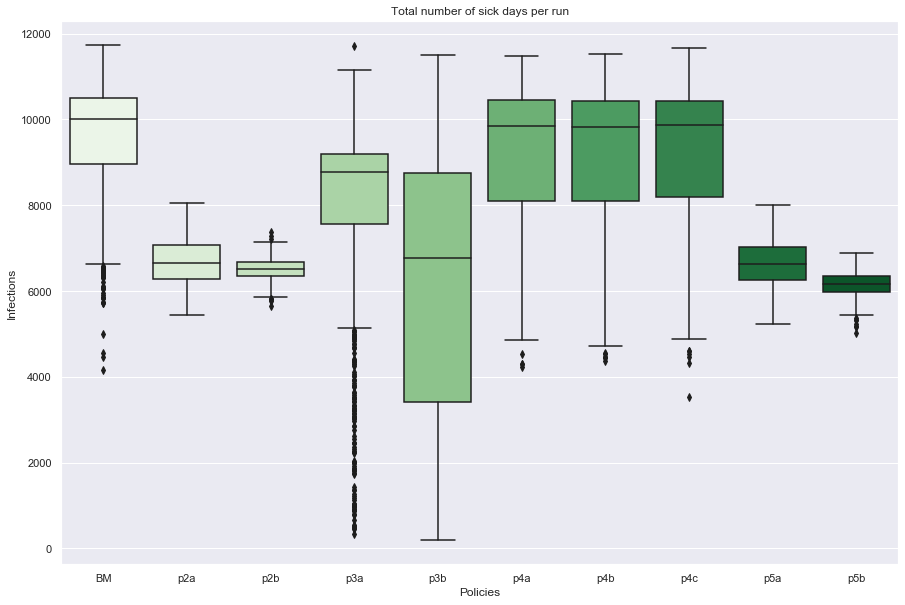

In [26]:
# creating boxplots to compare interventions based on the KPIs
sns.boxplot(x = ['BM', 'p2a', 'p2b', 'p3a', 'p3b', 'p4a', 'p4b','p4c', 'p5a', 'p5b',], 
            y=[ total_inf_0, 
                total_inf_2a,total_inf_2b ,
               total_inf_3a,total_inf_3b ,
               total_inf_4a,total_inf_4b,total_inf_4c,
              total_inf_1a ,total_inf_1b], 
            palette = 'Greens')
sns.set(rc={'figure.figsize':(15,10)})
plt.ylabel('Infections')
plt.xlabel('Policies')
plt.title("Total number of sick days per run")

plt.show()

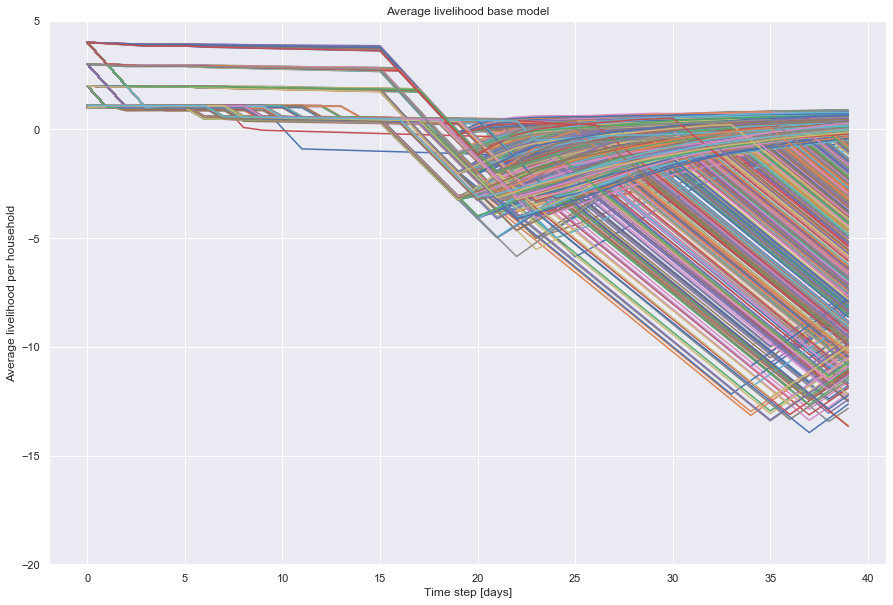

In [14]:
# plotting the adoption curves - here: for cash-transfer-only (p1)
from ema_workbench.analysis import plotting, plotting_util

for outcome in outcomes0.keys():
    if outcome == 'Avg_livelihood':
        plotting.lines(experiments0, outcomes0, titles = None, outcomes_to_show=outcome)

plt.xlabel('Time step [days]')
plt.ylabel('Average livelihood per household')
plt.title("Average livelihood base model")
plt.ylim(-20, 5)
plt.show()

In [15]:
df = pd.DataFrame(outcomes0["Avg_livelihood"])
df2 = pd.DataFrame(outcomes2b["Avg_livelihood"])
df.head()

0       1       2       3       4       5       6       7       8   \
0  1.1065  1.1050  1.1035  1.1050  1.1045  1.1060  0.5885  0.5710  0.5535   
1  1.0000  1.0005  1.0010  1.0030  1.0025  1.0010  0.4875  0.4735  0.4600   
2  3.0000  2.0000  1.0000  1.0060  1.0040  1.0090  1.0080  1.0070  0.4935   
3  1.1230  1.1250  1.1220  1.1215  1.1270  1.1245  0.6155  0.6060  0.5965   
4  1.0000  1.0995  1.0960  1.0925  1.0855  1.0770  1.0725  1.0745  1.0710   

       9   ...      30      31      32      33      34      35      36  \
0  0.5360  ... -0.7615 -0.6260 -0.4925 -0.3615 -0.2455 -0.1555 -0.0845   
1  0.4465  ... -0.7820 -0.6605 -0.5935 -0.5150 -0.4635 -0.3720 -0.3260   
2  0.4800  ... -0.9760 -0.7740 -0.6245 -0.4740 -0.3750 -1.1170 -1.8480   
3  0.5870  ... -0.8725 -0.6980 -0.5535 -0.4275 -0.3065 -0.2100 -0.1060   
4  1.0735  ... -0.7560 -0.6095 -0.4855 -0.3880 -0.2675 -0.1715 -0.0890   

       37      38      39  
0 -0.0190  0.0285 -0.6990  
1 -0.2750 -0.2275 -0.1835  
2 -2.5865 -3.3180 -4.0495  
3 -0.0225  0.0530  0.1480  
4 -0.0015  0.0960  0.1475  

[5 rows x 40 columns]

In [16]:
df = pd.DataFrame(outcomes3a["Infected"])
df2 = pd.DataFrame(outcomes3b["Infected"])

In [17]:
import statistics as st
import math

df.loc['mean'] = df.mean()
df.loc["error"] = df.std()
df2.loc['mean'] = df2.mean()
df2.loc['error'] = df2.std()
#df.loc["stdev"] = math.sqrt(df["var"])
#df.loc['error'] = df.loc["max"] - df.loc["mean"]
df2

0    1    2    3          4          5          6           7   \
0      0.0  0.0  0.0  0.0  18.000000  19.000000  19.000000  106.000000   
1      0.0  0.0  0.0  0.0  11.000000   9.000000   9.000000   56.000000   
2      0.0  0.0  0.0  0.0  17.000000  19.000000  24.000000   22.000000   
3      0.0  0.0  0.0  0.0  20.000000  22.000000  24.000000   44.000000   
4      0.0  0.0  0.0  0.0  20.000000  25.000000  28.000000   29.000000   
...    ...  ...  ...  ...        ...        ...        ...         ...   
997    0.0  0.0  0.0  0.0  21.000000  20.000000  17.000000   28.000000   
998    0.0  0.0  0.0  0.0  18.000000  26.000000  36.000000   33.000000   
999    0.0  0.0  0.0  0.0  17.000000  33.000000  51.000000   53.000000   
mean   0.0  0.0  0.0  0.0  16.708000  30.258000  44.830000   70.375000   
error  0.0  0.0  0.0  0.0   4.011326  21.704411  39.726126   58.471706   

               8           9   ...          30          31          32  \
0      121.000000  144.000000  ...  286.000000  271.000000  252.000000   
1      143.000000  215.000000  ...  240.000000  224.000000  212.000000   
2       20.000000   18.000000  ...  252.000000  236.000000  224.000000   
3       56.000000   71.000000  ...  104.000000  106.000000  100.000000   
4       28.000000   29.000000  ...   42.000000   45.000000   46.000000   
...           ...         ...  ...         ...         ...         ...   
997     56.000000   70.000000  ...  120.000000  114.000000  102.000000   
998     34.000000  119.000000  ...  285.000000  271.000000  250.000000   
999     49.000000   54.000000  ...   75.000000   69.000000   59.000000   
mean   101.809000  135.465000  ...  168.682000  161.914000  154.859000   
error   80.271941  103.439223  ...   79.362969   75.792985   72.277224   

               33         34         35          36          37         38  \
0      237.000000  223.00000  203.00000  194.000000  179.000000  167.00000   
1      198.000000  186.00000  170.00000  163.000000  155.000000  143.00000   
2      213.000000  202.00000  188.00000  169.000000  155.000000  137.00000   
3       94.000000   87.00000   87.00000   81.000000   80.000000   75.00000   
4       46.000000   47.00000   43.00000   42.000000   37.000000   41.00000   
...           ...        ...        ...         ...         ...        ...   
997     95.000000   85.00000   79.00000   74.000000   66.000000   64.00000   
998    236.000000  225.00000  208.00000  196.000000  184.000000  176.00000   
999     59.000000   62.00000   60.00000   60.000000   62.000000   60.00000   
mean   147.895000  141.01300  134.56900  128.078000  121.879000  115.75900   
error   69.018751   65.97288   63.40318   60.781559   58.277477   55.81076   

               39  
0      160.000000  
1      135.000000  
2      127.000000  
3       74.000000  
4       37.000000  
...           ...  
997     62.000000  
998    165.000000  
999     59.000000  
mean   109.951000  
error   53.568746  

[1002 rows x 40 columns]

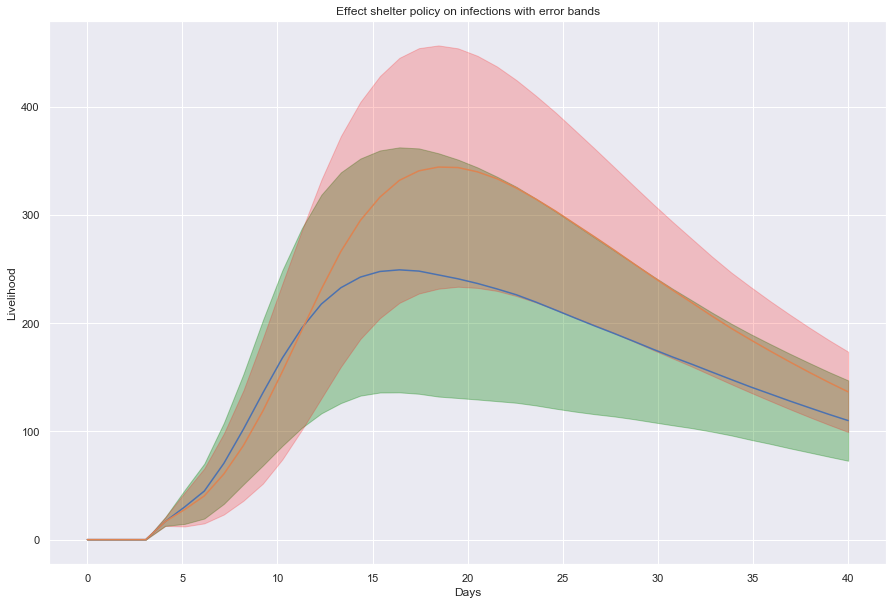

In [18]:
x = np.linspace(0, 40, 40)
y = df.loc["mean"]
z = df2.loc["mean"]
error = df.loc["error"]
errorz = df2.loc["error"]

plt.plot(x, z, '-')
plt.fill_between(x, z-error, z+error, alpha = 0.3, color = "green")
plt.plot(x, y, '-')
plt.fill_between(x, y-error, y+error, alpha = 0.2, color = "red")
plt.title("Effect shelter policy on infections with error bands")
plt.xlabel("Days")
plt.ylabel("Livelihood")
plt.show()

In [19]:
## error bands with cash transfers

In [20]:
df = pd.DataFrame(outcomes4a["Avg_livelihood"])
df2 = pd.DataFrame(outcomes4c["Avg_livelihood"])
df3 = pd.DataFrame(outcomes0["Avg_livelihood"])
df.head()

df.loc['mean'] = df.mean()
df.loc["error"] = df.std()
df2.loc['mean'] = df2.mean()
df2.loc['error'] = df2.std()
df3.loc['mean'] = df3.mean()
df3.loc['error'] = df3.std()
#df.loc["stdev"] = math.sqrt(df["var"])
#df.loc['error'] = df.loc["max"] - df.loc["mean"]
df3

0         1         2         3         4         5         6   \
0      1.106500  1.105000  1.103500  1.105000  1.104500  1.106000  0.588500   
1      1.000000  1.000500  1.001000  1.003000  1.002500  1.001000  0.487500   
2      3.000000  2.000000  1.000000  1.006000  1.004000  1.009000  1.008000   
3      1.123000  1.125000  1.122000  1.121500  1.127000  1.124500  0.615500   
4      1.000000  1.099500  1.096000  1.092500  1.085500  1.077000  1.072500   
...         ...       ...       ...       ...       ...       ...       ...   
997    3.000000  2.960000  2.920000  2.925000  2.923000  2.923000  2.889000   
998    1.000000  1.100000  1.087000  1.085000  1.083000  1.083000  1.089000   
999    1.097500  1.091500  1.088500  1.091500  1.091500  1.091000  1.091000   
mean   2.218403  1.782824  1.532225  1.472628  1.474218  1.473482  1.421600   
error  1.147700  0.914255  0.803426  0.791191  0.791402  0.791667  0.822313   

             7         8         9   ...        30        31        32  \
0      0.571000  0.553500  0.536000  ... -0.761500 -0.626000 -0.492500   
1      0.473500  0.460000  0.446500  ... -0.782000 -0.660500 -0.593500   
2      1.007000  0.493500  0.480000  ... -0.976000 -0.774000 -0.624500   
3      0.606000  0.596500  0.587000  ... -0.872500 -0.698000 -0.553500   
4      1.074500  1.071000  1.073500  ... -0.756000 -0.609500 -0.485500   
...         ...       ...       ...  ...       ...       ...       ...   
997    2.875000  2.861000  2.847000  ...  0.258500  0.293000  0.324000   
998    1.083000  0.565500  0.547500  ... -1.154500 -0.982000 -0.837000   
999    0.581000  0.569000  0.557000  ... -0.997000 -0.840000 -0.690500   
mean   1.382664  1.250417  1.147293  ... -1.357603 -1.399430 -1.478678   
error  0.842097  0.911656  0.949717  ...  1.837035  2.086882  2.354656   

             33        34        35        36        37        38        39  
0     -0.361500 -0.245500 -0.155500 -0.084500 -0.019000  0.028500 -0.699000  
1     -0.515000 -0.463500 -0.372000 -0.326000 -0.275000 -0.227500 -0.183500  
2     -0.474000 -0.375000 -1.117000 -1.848000 -2.586500 -3.318000 -4.049500  
3     -0.427500 -0.306500 -0.210000 -0.106000 -0.022500  0.053000  0.148000  
4     -0.388000 -0.267500 -0.171500 -0.089000 -0.001500  0.096000  0.147500  
...         ...       ...       ...       ...       ...       ...       ...  
997    0.365500  0.410000  0.455500 -0.279000 -1.014000 -1.743500 -2.474000  
998   -0.704500 -0.607000 -0.483500 -0.385000 -0.298500 -0.218500 -0.140500  
999   -0.564500 -0.448500 -0.353000 -0.267000 -0.172000 -0.104000 -0.007500  
mean  -1.593929 -1.742096 -1.924259 -2.140835 -2.382640 -2.639295 -2.893587  
error  2.635684  2.919479  3.185427  3.414959  3.616001  3.775994  3.901829  

[1002 rows x 40 columns]

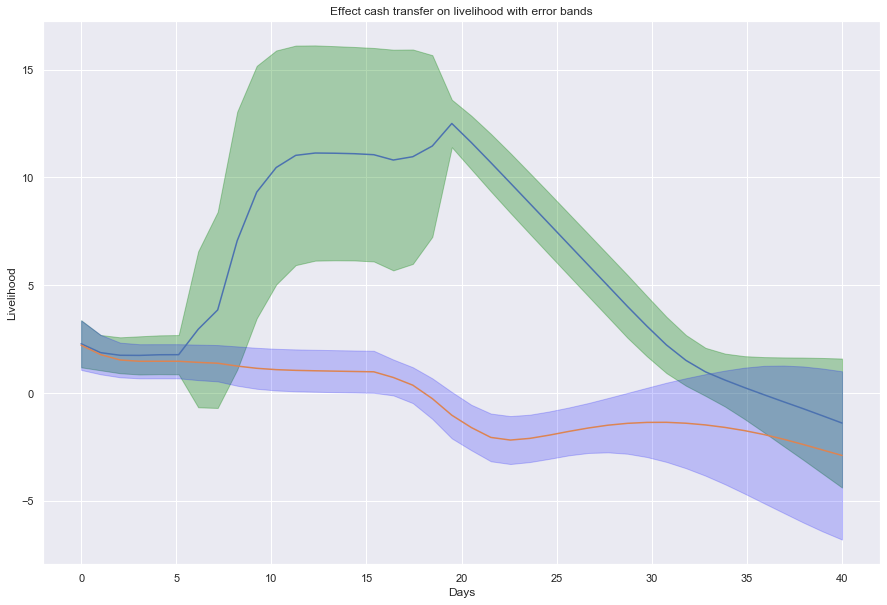

In [21]:
x = np.linspace(0, 40, 40)
y = df.loc["mean"]
z = df2.loc["mean"]
k = df3.loc["mean"]
error = df.loc["error"]
errorz = df2.loc["error"]
errork = df3.loc["error"]

plt.plot(x, z, '-')
plt.fill_between(x, z-errorz, z+errorz, alpha = 0.3, color = "green")
# plt.plot(x, y, '-')
# plt.fill_between(x, y-error, y+error, alpha = 0.2, color = "red")
plt.plot(x,k,'-')
plt.fill_between(x, k-errork, k+errork, alpha = 0.2, color = "blue")

plt.title("Effect cash transfer on livelihood with error bands")
plt.xlabel("Days")
plt.ylabel("Livelihood")
plt.show()

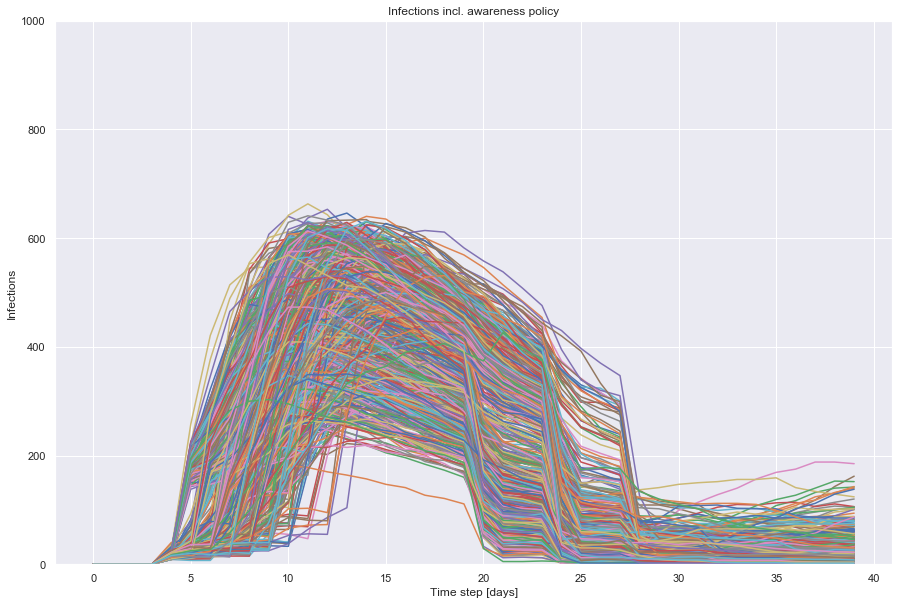

In [22]:
# plotting the adoption curves - here: for cash-transfer-only (p1)
from ema_workbench.analysis import plotting, plotting_util

for outcome in outcomes2b.keys():
    if outcome == 'Infected':
        plotting.lines(experiments2b, outcomes2b, titles = None, outcomes_to_show=outcome)

plt.xlabel('Time step [days]')
plt.ylabel('Infections')
plt.title("Infections incl. awareness policy")
plt.ylim(0, 1000)
plt.show()

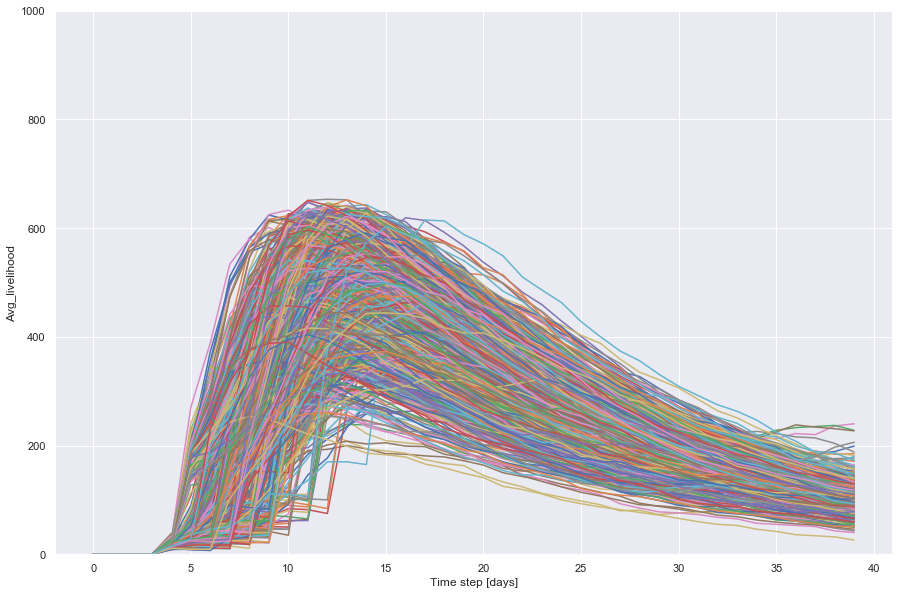

In [23]:
# plotting the adoption curves - here: for cash-transfer-only (p1)
from ema_workbench.analysis import plotting, plotting_util

for outcome in outcomes0.keys():
    if outcome == 'Infected':
        plotting.lines(experiments0, outcomes0, titles = None, outcomes_to_show=outcome)

plt.xlabel('Time step [days]')
plt.ylabel('Avg_livelihood')
plt.ylim(0, 1000)
plt.show()

In [21]:
#total area under graph infections
nega_liv_0 = []
nega_liv_1a = []
nega_liv_1b = []
nega_liv_2a = []
nega_liv_2b = []
nega_liv_3a = []
nega_liv_3b = []
nega_liv_3c = []
nega_liv_4a = []
nega_liv_4b = []
nega_liv_4c = []

for i in range(1000):
    neg0 = (outcomes0["Avg_livelihood"][i]<0)*outcomes0["Avg_livelihood"][i]
    nega_liv_0.append(neg0.sum())
    neg1a = (outcomes1a["Avg_livelihood"][i]<0)*outcomes1a["Avg_livelihood"][i]
    nega_liv_1a.append(neg1a.sum())
    neg1b = (outcomes1b["Avg_livelihood"][i]<0)*outcomes1b["Avg_livelihood"][i]
    nega_liv_1b.append(neg1b.sum())
    neg2a = (outcomes2a["Avg_livelihood"][i]<0)*outcomes2a["Avg_livelihood"][i]
    nega_liv_2a.append(neg2a.sum())
    neg2b = (outcomes2b["Avg_livelihood"][i]<0)*outcomes2b["Avg_livelihood"][i]
    nega_liv_2b.append(neg2b.sum())
    neg3a = (outcomes3a["Avg_livelihood"][i]<0)*outcomes3a["Avg_livelihood"][i]
    nega_liv_3a.append(neg3a.sum())
    neg3b = (outcomes3b["Avg_livelihood"][i]<0)*outcomes3b["Avg_livelihood"][i]
    nega_liv_3b.append(neg3b.sum())
    neg3c = (outcomes3c["Avg_livelihood"][i]<0)*outcomes3c["Avg_livelihood"][i]
    nega_liv_3c.append(neg3c.sum())    
    
    neg4a = (outcomes4a["Avg_livelihood"][i]<0)*outcomes4a["Avg_livelihood"][i]
    nega_liv_4a.append(neg4a.sum())
    neg4b = (outcomes4b["Avg_livelihood"][i]<0)*outcomes4b["Avg_livelihood"][i]
    nega_liv_4b.append(neg4b.sum())
    neg4c = (outcomes4c["Avg_livelihood"][i]<0)*outcomes4c["Avg_livelihood"][i]
    nega_liv_4c.append(neg4c.sum())


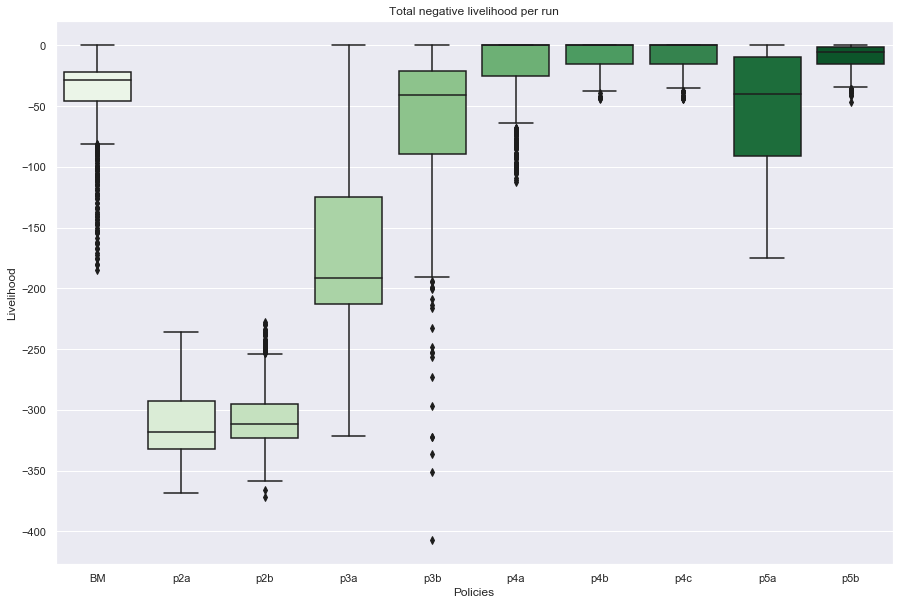

In [25]:
# creating boxplots to compare interventions based on the KPIs
sns.boxplot(x = ['BM','p2a', 'p2b', 'p3a', 'p3b', 'p4a', 'p4b','p4c', 'p5a', 'p5b'], 
            y=[ nega_liv_0, 

               nega_liv_2a,nega_liv_2b ,
               nega_liv_3a,
                nega_liv_3b,
               nega_liv_4a,nega_liv_4b,nega_liv_4c,
               nega_liv_1a ,nega_liv_1b], 
            palette = 'Greens')
sns.set(rc={'figure.figsize':(15,10)})
plt.ylabel('Livelihood')
plt.xlabel('Policies')
plt.title("Total negative livelihood per run")
plt.show()

In [26]:
experiments1a.head()

corona_fraction  growth_threshold  initial_live  livelihood_threshold  \
0         0.093085              12.0           5.0                   7.0   
1         0.017728               7.0           4.0                   3.0   
2         0.162048               4.0           4.0                   9.0   
3         0.027842               2.0           5.0                  10.0   
4         0.164563               3.0           2.0                   6.0   

   max_contacts  max_contacts_shelter  med_contacts  min_contacts scenario  \
0           4.0                  15.0           3.0           1.0        0   
1           4.0                  10.0           2.0           1.0        1   
2           3.0                   9.0           2.0           2.0        2   
3           5.0                  12.0           2.0           1.0        3   
4           5.0                  16.0           3.0           1.0        4   

  policy     model  
0   None  livmodel  
1   None  livmodel  
2   None  livmodel  
3   None  livmodel  
4   None  livmodel

In [27]:
x = pd.DataFrame(nega_liv_1a)
x['sick'] = total_inf_1a
x['cor_frac'] = experiments1a.corona_fraction
x['R'] = experiments1a.growth_threshold
x['liv_threshold'] = experiments1a.livelihood_threshold
x.columns = ['sum neg liv', 'total_sick_days', 'cor_frac', 'R', 'liv_threshold']
x

sum neg liv  total_sick_days  cor_frac     R  liv_threshold
0       -10.2710             9600  0.093085  12.0            7.0
1       -90.5430             9847  0.017728   7.0            3.0
2      -187.1440             7643  0.162048   4.0            9.0
3      -191.4815             7503  0.027842   2.0           10.0
4      -243.3445             7336  0.164563   3.0            6.0
..           ...              ...       ...   ...            ...
995     -52.9930             8821  0.041774   8.0            7.0
996      -8.5150            10970  0.024069  12.0            5.0
997     -99.4285             9032  0.174080   6.0            3.0
998    -204.8665             6628  0.102209   2.0            8.0
999     -25.4645            11115  0.100249  11.0            8.0

[1000 rows x 5 columns]

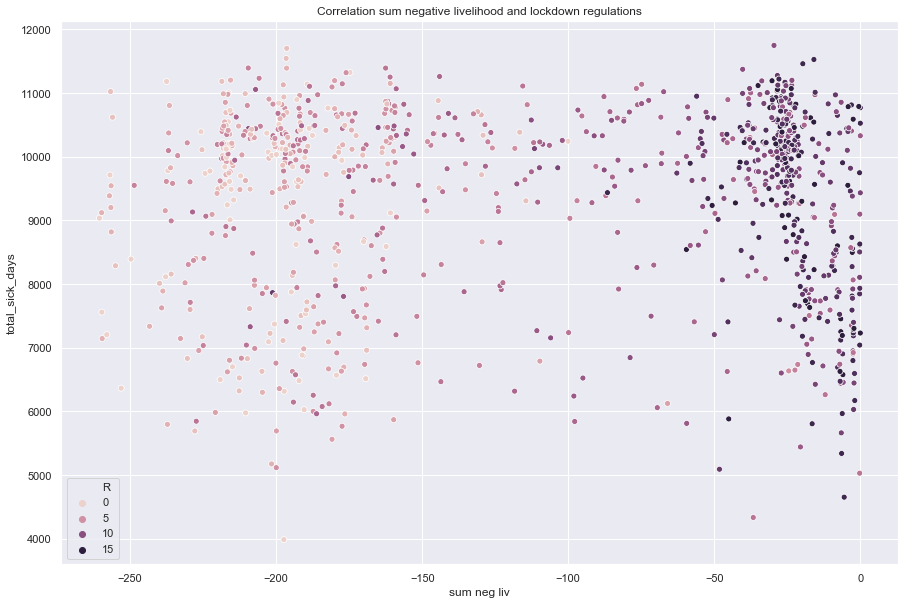

In [28]:
#What you see: max infected runs in relation to the size of the shelter in relation to the number of shelters
sns.scatterplot(data=x, x="sum neg liv", y="total_sick_days", hue ="R")
sns.set(rc={'figure.figsize':(15,10)})
plt.title("Correlation sum negative livelihood and lockdown regulations")
plt.show()

In [29]:
x.head()
x['Rv'] = "<= 4"
for i in range(len(x)):
    if x.R[i] > 4 and x.R[i] < 9:
        x.Rv[i] = "5 - 8"
    elif x.R[i] >8 and x.R[i] < 12:
        x.Rv[i] = "9 - 11"
    elif x.R[i] > 11:
        x.Rv[i] = "12 - 15"
    else:
        pass
x.head()


C:\Users\fuukv\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\fuukv\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\fuukv\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


sum neg liv  total_sick_days  cor_frac     R  liv_threshold       Rv
0     -10.2710             9600  0.093085  12.0            7.0  12 - 15
1     -90.5430             9847  0.017728   7.0            3.0    5 - 8
2    -187.1440             7643  0.162048   4.0            9.0     <= 4
3    -191.4815             7503  0.027842   2.0           10.0     <= 4
4    -243.3445             7336  0.164563   3.0            6.0     <= 4

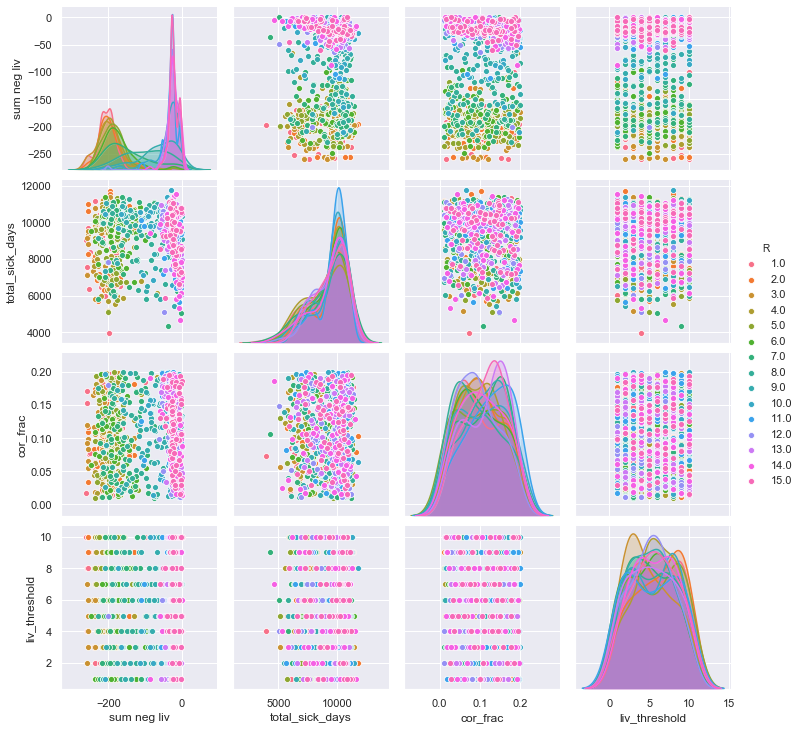

In [30]:
sns.pairplot(x, hue="R")

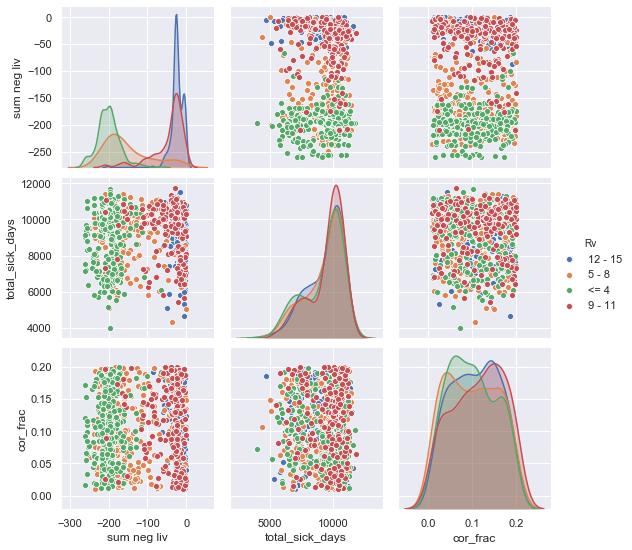

In [31]:
xx = x[["sum neg liv", "total_sick_days", "cor_frac", "Rv"]]
sns.pairplot(xx, hue="Rv")
#plt.title("Pairplot growth_threshold, total infected days and negative livelihood")

In [32]:
# check the range of infections per policy scenario

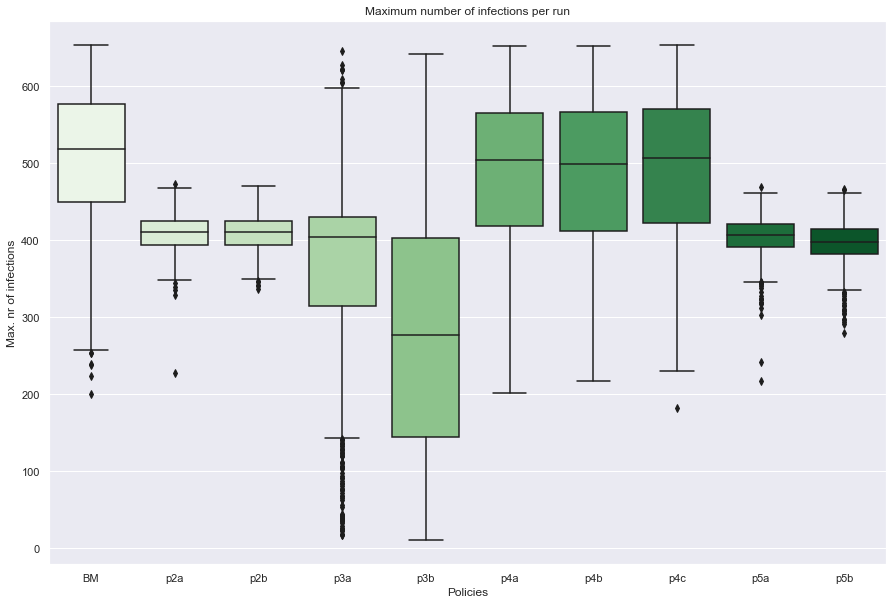

In [17]:
# creating boxplots to compare interventions based on the KPIs
sns.boxplot(x = ['BM','p2a', 'p2b', 'p3a', 'p3b', 'p4a', 'p4b','p4c', 'p5a', 'p5b'], 
            y=[outcomes0["Infected"][np.arange(len(outcomes0["Infected"])), np.argmax(outcomes0["Infected"], axis=1)]  , 
               outcomes2a["Infected"][np.arange(len(outcomes2a["Infected"])), np.argmax(outcomes2a["Infected"], axis=1)]  ,
               outcomes2b["Infected"][np.arange(len(outcomes2b["Infected"])), np.argmax(outcomes2b["Infected"], axis=1)]  ,
               outcomes3a["Infected"][np.arange(len(outcomes3a["Infected"])), np.argmax(outcomes3a["Infected"], axis=1)],  
               outcomes3b["Infected"][np.arange(len(outcomes3b["Infected"])), np.argmax(outcomes3b["Infected"], axis=1)] , 
               outcomes4a["Infected"][np.arange(len(outcomes4a["Infected"])), np.argmax(outcomes4a["Infected"], axis=1)]  ,
               outcomes4b["Infected"][np.arange(len(outcomes4b["Infected"])), np.argmax(outcomes4b["Infected"], axis=1)] ,
              outcomes4c["Infected"][np.arange(len(outcomes4c["Infected"])), np.argmax(outcomes4c["Infected"], axis=1)] ,
            outcomes1a["Infected"][np.arange(len(outcomes1a["Infected"])), np.argmax(outcomes1a["Infected"], axis=1)]  ,
               outcomes1b["Infected"][np.arange(len(outcomes1b["Infected"])), np.argmax(outcomes1b["Infected"], axis=1)]  ], 
            palette = 'Greens')
sns.set(rc={'figure.figsize':(15,10)})
plt.ylabel('Max. nr of infections')
plt.xlabel('Policies')
plt.title("Maximum number of infections per run")
plt.show()

In [34]:
#check the same for average livelihood

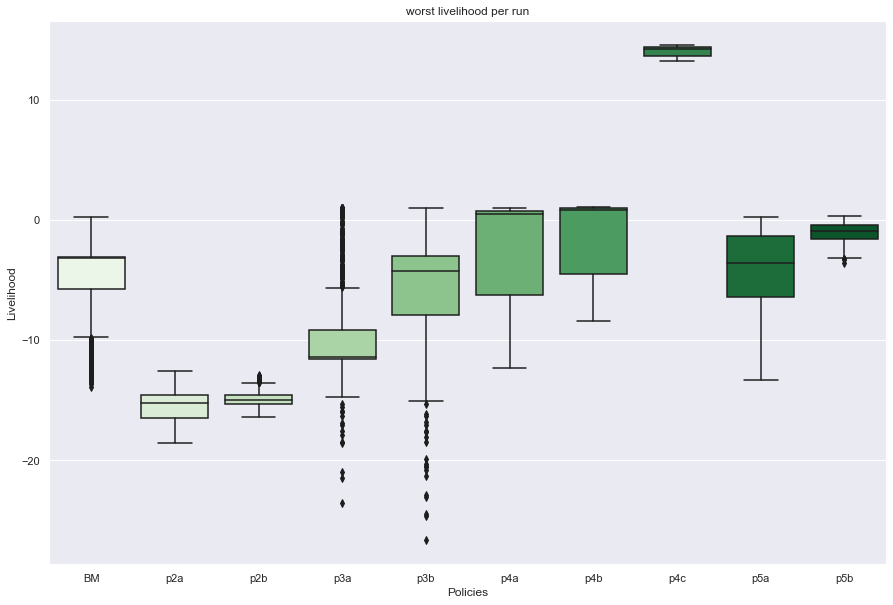

In [20]:
# creating boxplots to compare interventions based on the KPIs
sns.boxplot(x = ['BM','p2a', 'p2b', 'p3a', 'p3b', 'p4a', 'p4b','p4c', 'p5a','p5b'], 
            y=[outcomes0["Avg_livelihood"][np.arange(len(outcomes0["Avg_livelihood"])), np.argmin(outcomes0["Avg_livelihood"], axis=1)]  , 
                
               outcomes2a["Avg_livelihood"][np.arange(len(outcomes2a["Avg_livelihood"])), np.argmin(outcomes2a["Avg_livelihood"], axis=1)]  ,
               outcomes2b["Avg_livelihood"][np.arange(len(outcomes2b["Avg_livelihood"])), np.argmin(outcomes2b["Avg_livelihood"], axis=1)]  ,
               outcomes3a["Avg_livelihood"][np.arange(len(outcomes3a["Avg_livelihood"])), np.argmin(outcomes3a["Avg_livelihood"], axis=1)],  
               outcomes3b["Avg_livelihood"][np.arange(len(outcomes3b["Avg_livelihood"])), np.argmin(outcomes3b["Avg_livelihood"], axis=1)] , 
               outcomes4a["Avg_livelihood"][np.arange(len(outcomes4a["Avg_livelihood"])), np.argmin(outcomes4a["Avg_livelihood"], axis=1)]  ,
               outcomes4b["Avg_livelihood"][np.arange(len(outcomes4b["Avg_livelihood"])), np.argmin(outcomes4b["Avg_livelihood"], axis=1)] ,
              outcomes4c["Avg_livelihood"][np.arange(len(outcomes4c["Avg_livelihood"])), np.argmax(outcomes4c["Avg_livelihood"], axis=1)],
              outcomes1a["Avg_livelihood"][np.arange(len(outcomes1a["Avg_livelihood"])), np.argmin(outcomes1a["Avg_livelihood"], axis=1)]  ,
               outcomes1b["Avg_livelihood"][np.arange(len(outcomes1b["Avg_livelihood"])), np.argmin(outcomes1b["Avg_livelihood"], axis=1)] ], 
            palette = 'Greens')
sns.set(rc={'figure.figsize':(15,10)})
plt.ylabel('Livelihood')
plt.xlabel('Policies')
plt.title("worst livelihood per run")
plt.show()

In [36]:
experiments4a.head()

initial_live  max_contacts  max_contacts_shelter  med_contacts  \
0           3.0           3.0                  15.0           2.0   
1           1.0           3.0                  16.0           3.0   
2           3.0           5.0                  13.0           3.0   
3           5.0           5.0                  11.0           2.0   
4           5.0           3.0                  13.0           2.0   

   min_contacts scenario policy     model  
0           1.0        0   None  livmodel  
1           2.0        1   None  livmodel  
2           1.0        2   None  livmodel  
3           2.0        3   None  livmodel  
4           2.0        4   None  livmodel

In [37]:
cc = outcomes3c["Avg_livelihood"][np.arange(len(outcomes3c["Avg_livelihood"])), np.argmin(outcomes3c["Avg_livelihood"], axis=1)]
ccc = outcomes3c["Infected"][np.arange(len(outcomes3c["Infected"])), np.argmax(outcomes3c["Infected"], axis=1)]
cc = pd.DataFrame(cc)
ccc = pd.DataFrame(ccc)
c = pd.DataFrame(total_inf_3c)
c2 = pd.DataFrame(nega_liv_3c)

f = pd.concat([c, cc, ccc, c2], axis = 1).reindex(cc.index)

f.columns = ["total inf", "min liv", "max infected", 'sum neg']
f["shelterfrac"] = experiments3c['shelter_frac']
f["numshel"] = experiments3c['num_shelters']
f["cash"] = experiments3c["height_cash"]

In [38]:
experiments3c.head()

height_cash  initial_live  max_contacts  max_contacts_shelter  \
0          8.0           1.0           9.0                   5.0   
1         14.0           3.0           6.0                   6.0   
2         22.0           5.0           7.0                  14.0   
3         24.0           5.0           5.0                  18.0   
4         25.0           1.0           8.0                  22.0   

   med_contacts  min_contacts  num_shelters  shelter_frac scenario policy  \
0           2.0           1.0          12.0      0.024835        0   None   
1           5.0           2.0          10.0      0.089200        1   None   
2           2.0           1.0          12.0      0.013131        2   None   
3           5.0           1.0          10.0      0.072416        3   None   
4           2.0           1.0           9.0      0.025677        4   None   

      model  
0  livmodel  
1  livmodel  
2  livmodel  
3  livmodel  
4  livmodel

In [39]:
f.head(10)

total inf  min liv  max infected  sum neg  shelterfrac  numshel  cash
0       9813  -4.9460           498 -68.7620     0.024835     12.0   8.0
1       9339   0.5755           453   0.0000     0.089200     10.0  14.0
2       9786   0.9070           520   0.0000     0.013131     12.0  22.0
3       9039   0.8470           425   0.0000     0.072416     10.0  24.0
4       9025   0.9390           455   0.0000     0.025677      9.0  25.0
5       2837  -2.6455           137 -14.5520     0.040274      5.0  13.0
6       4597   1.3595           231   0.0000     0.055437     11.0  25.0
7      10238   0.7645           553   0.0000     0.082965     13.0  18.0
8       9593  -4.4820           466 -50.6030     0.074980     11.0   8.0
9      10324  -3.7905           567 -10.0455     0.085783     13.0  17.0

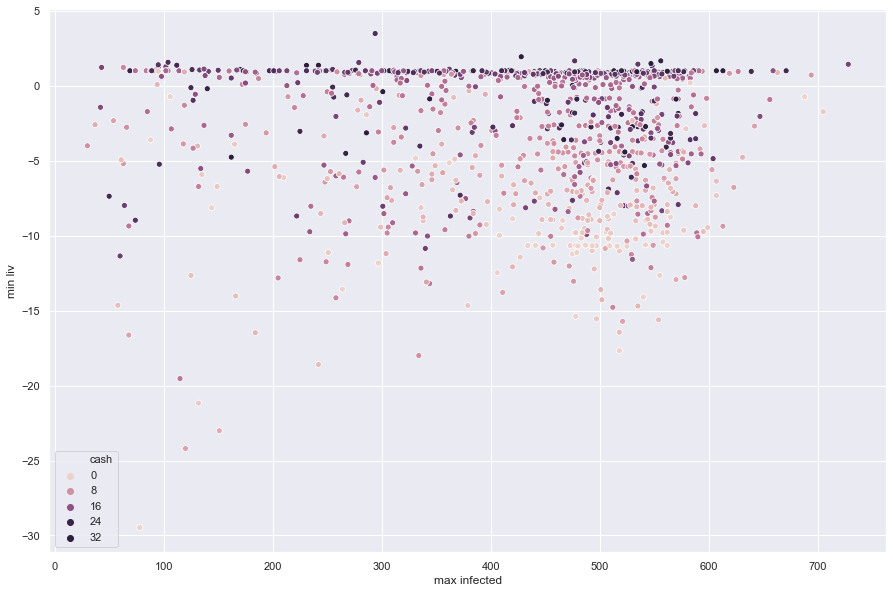

In [40]:
sns.scatterplot(data = f, x="max infected", y="min liv", hue ="cash")
sns.set(rc={'figure.figsize':(15,10)})
plt.show()

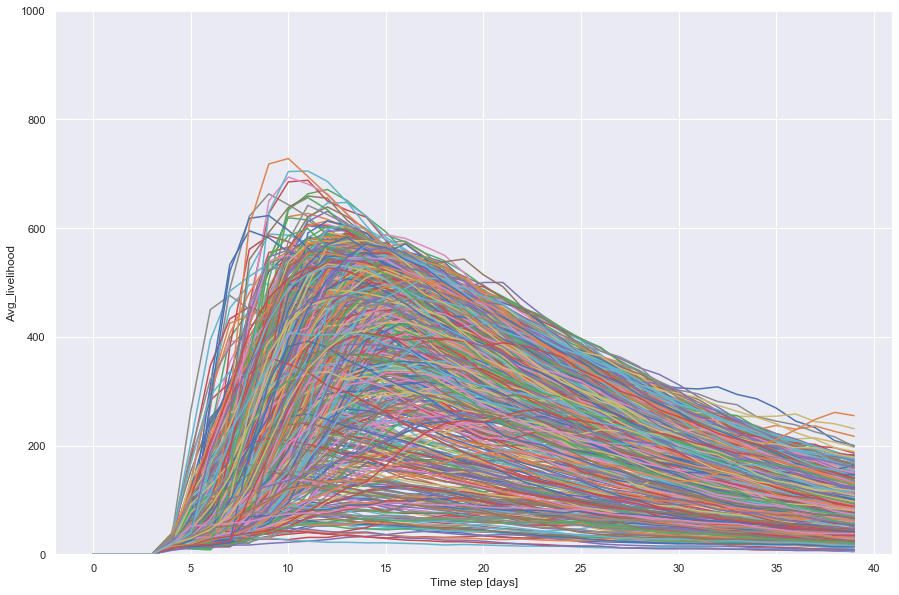

In [41]:
# plotting the adoption curves - here: for cash-transfer-only (p1)
from ema_workbench.analysis import plotting, plotting_util

for outcome in outcomes3c.keys():
    if outcome == 'Infected':
        plotting.lines(experiments3c, outcomes3c, titles = None, outcomes_to_show=outcome)

plt.xlabel('Time step [days]')
plt.ylabel('Avg_livelihood')
plt.ylim(0, 1000)
plt.show()

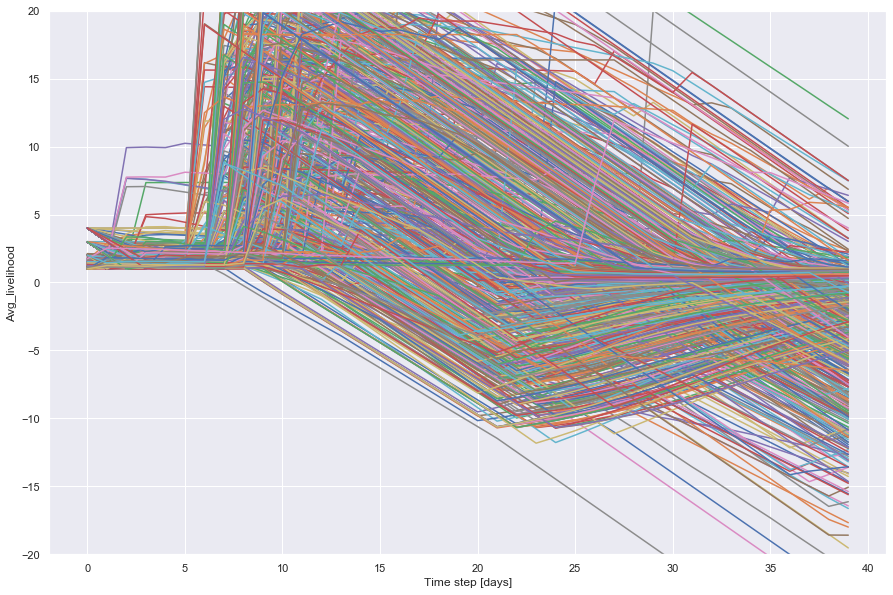

In [42]:
# plotting the adoption curves - here: for cash-transfer-only (p1)
from ema_workbench.analysis import plotting, plotting_util

for outcome in outcomes3c.keys():
    if outcome == 'Avg_livelihood':
        plotting.lines(experiments3c, outcomes3c, titles = None, outcomes_to_show=outcome)

plt.xlabel('Time step [days]')
plt.ylabel('Avg_livelihood')
plt.ylim(-20, 20)
plt.show()

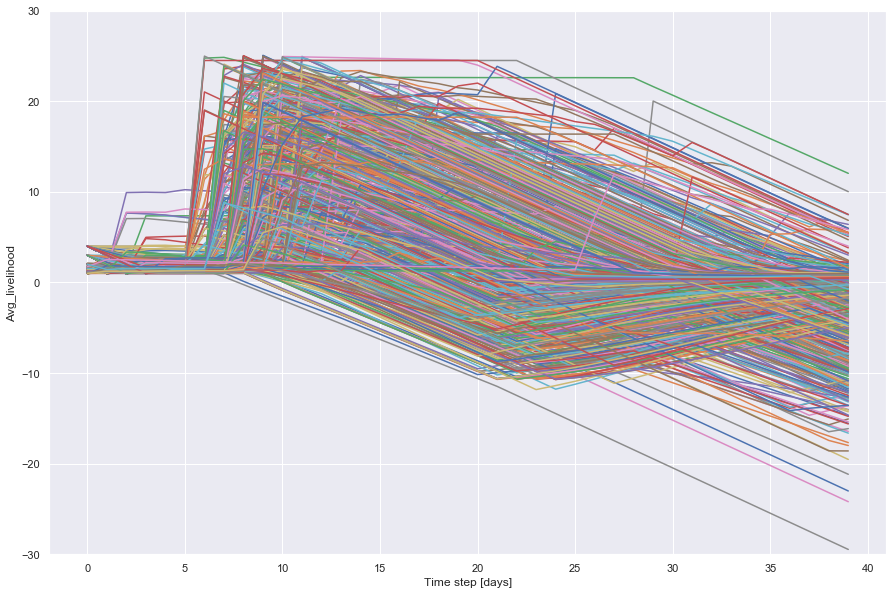

In [43]:
# plotting the adoption curves - here: for cash-transfer-only (p1)
from ema_workbench.analysis import plotting, plotting_util

for outcome in outcomes3c.keys():
    if outcome == 'Avg_livelihood':
        plotting.lines(experiments3c, outcomes3c, titles = None, outcomes_to_show=outcome)

plt.xlabel('Time step [days]')
plt.ylabel('Avg_livelihood')
plt.ylim(-30,30)
plt.show()

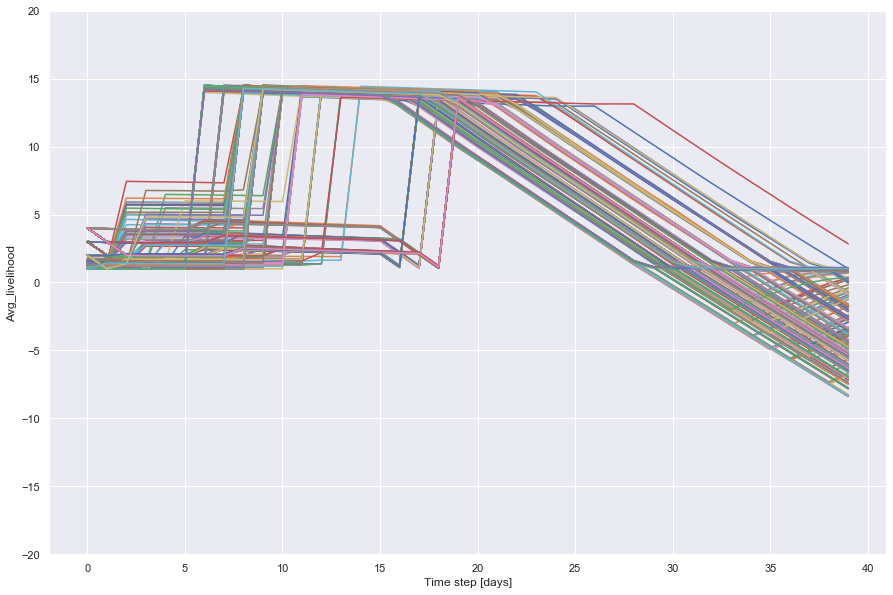

In [44]:
# plotting the adoption curves - here: for cash-transfer-only (p1)
from ema_workbench.analysis import plotting, plotting_util

for outcome in outcomes4c.keys():
    if outcome == 'Avg_livelihood':
        plotting.lines(experiments4c, outcomes4c, titles = None, outcomes_to_show=outcome)

plt.xlabel('Time step [days]')
plt.ylabel('Avg_livelihood')
plt.ylim(-20,20)
plt.show()

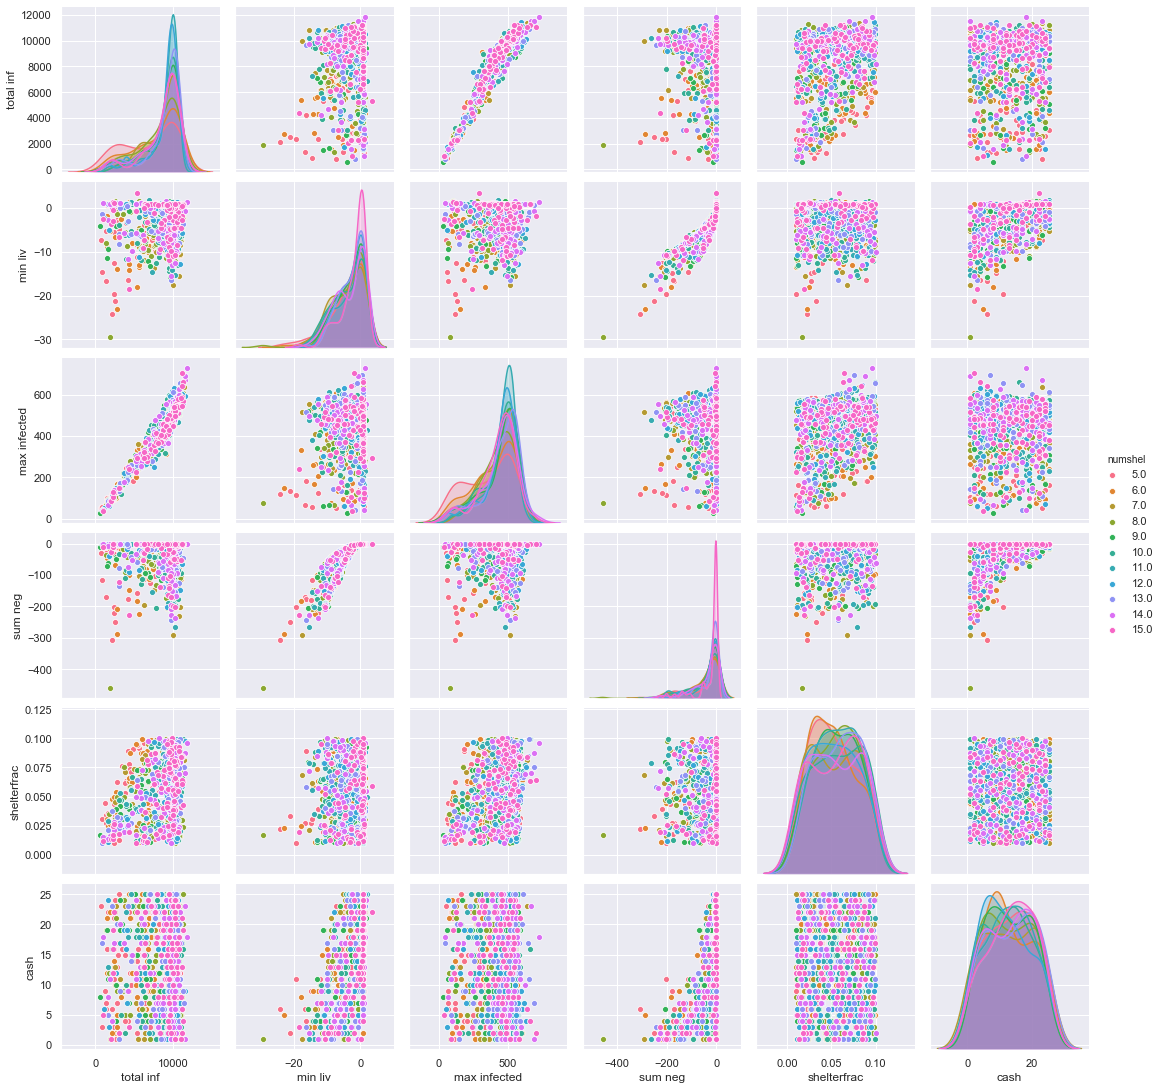

In [45]:
sns.pairplot(f, hue = "numshel")

In [46]:
experiments3a.head()

initial_live  num_shelters  shelter_frac  shelter_perc_meeting scenario  \
0           3.0          11.0      0.090368              0.077724     2000   
1           1.0          15.0      0.092420              0.074107     2001   
2           1.0          19.0      0.043743              0.135236     2002   
3           1.0          13.0      0.094155              0.064385     2003   
4           5.0          20.0      0.057300              0.167173     2004   

  policy     model  
0   None  livmodel  
1   None  livmodel  
2   None  livmodel  
3   None  livmodel  
4   None  livmodel

In [47]:
aa = outcomes3a["Avg_livelihood"][np.arange(len(outcomes3a["Avg_livelihood"])), np.argmin(outcomes3a["Avg_livelihood"], axis=1)]
bb = outcomes3b["Avg_livelihood"][np.arange(len(outcomes3b["Avg_livelihood"])), np.argmin(outcomes3b["Avg_livelihood"], axis=1)]
aaa = outcomes3a["Infected"][np.arange(len(outcomes3a["Infected"])), np.argmax(outcomes3a["Infected"], axis=1)]
bbb = outcomes3b["Infected"][np.arange(len(outcomes3b["Infected"])), np.argmax(outcomes3b["Infected"], axis=1)]


#cc = outcomes4c["Avg_livelihood"][np.arange(len(outcomes4c["Avg_livelihood"])), np.argmax(outcomes4c["Avg_livelihood"], axis=1)]

In [48]:
aa = pd.DataFrame(aa)
bb = pd.DataFrame(bb)
aa.columns = ["min liv"]
bb.columns = ["min liv"]
aaa = pd.DataFrame(aaa)
bbb = pd.DataFrame(bbb)
aaa.columns = ['max infected']
bbb.columns = ['max infected']

In [49]:
jup = pd.DataFrame(total_inf_3a)
jep = pd.DataFrame(total_inf_3b)

In [50]:
z = pd.concat([aaa,aa], axis = 1).reindex(aa.index)
zz = pd.concat([bbb,bb], axis = 1).reindex(bb.index)
z["shelter_frac"] = experiments3a['shelter_frac']
zz["shelter_frac"] = experiments3b['shelter_frac']
z['num_shelters'] = experiments3a['num_shelters']
zz['num_shelters'] = experiments3b['num_shelters']
z['total sick'] = jup
zz['total sick'] = jep
z['shelter_perc_meeting'] = experiments3a['shelter_perc_meeting']
zz['shelter_perc_meeting'] = experiments3b['shelter_perc_meeting']
#z["max shelter contacts"] = experiments3a["max_contacts_shelter"]
#zz["max shelter contacts"] = experiments3b["max_contacts_shelter"]

In [51]:
z.head()

max infected  min liv  shelter_frac  num_shelters  total sick  \
0           370 -10.8405      0.090368          11.0        8458   
1           462 -11.5855      0.092420          15.0        9902   
2           421 -11.5860      0.043743          19.0        9362   
3           433   0.5800      0.094155          13.0        9742   
4           264  -1.9415      0.057300          20.0        6733   

   shelter_perc_meeting  
0              0.077724  
1              0.074107  
2              0.135236  
3              0.064385  
4              0.167173

In [52]:
zz.head()

max infected  min liv  shelter_frac  num_shelters  total sick  \
0           447  -3.2420      0.086892          11.0        9941   
1           400  -4.0235      0.059706          20.0        8974   
2           386  -4.7245      0.049893          17.0        7902   
3           135 -11.7475      0.029663          16.0        3463   
4            47  -0.9355      0.019893          11.0        1435   

   shelter_perc_meeting  
0              0.075168  
1              0.189673  
2              0.141060  
3              0.102444  
4              0.098377

In [53]:
zzz = pd.concat([z,zz])

In [54]:
#zzz["total sick"] = pd.DataFrame(total_inf_)
zzz.head()

max infected  min liv  shelter_frac  num_shelters  total sick  \
0           370 -10.8405      0.090368          11.0        8458   
1           462 -11.5855      0.092420          15.0        9902   
2           421 -11.5860      0.043743          19.0        9362   
3           433   0.5800      0.094155          13.0        9742   
4           264  -1.9415      0.057300          20.0        6733   

   shelter_perc_meeting  
0              0.077724  
1              0.074107  
2              0.135236  
3              0.064385  
4              0.167173

In [55]:
#zzz["max shelter contacts"][0]
zzz.reset_index(drop=True, inplace=True)

In [56]:
z.head()

max infected  min liv  shelter_frac  num_shelters  total sick  \
0           370 -10.8405      0.090368          11.0        8458   
1           462 -11.5855      0.092420          15.0        9902   
2           421 -11.5860      0.043743          19.0        9362   
3           433   0.5800      0.094155          13.0        9742   
4           264  -1.9415      0.057300          20.0        6733   

   shelter_perc_meeting  
0              0.077724  
1              0.074107  
2              0.135236  
3              0.064385  
4              0.167173

In [57]:
zzz['Rv'] = "<6"
for i in range(len(zzz)):
    if zzz["max shelter contacts"][i] > 8 and zzz["max shelter contacts"][i] < 15:
        zzz.Rv[i] = "6 - 15"
    elif zzz["max shelter contacts"][i] > 14:
        zzz.Rv[i] = ">14"
    else:
        pass
zzz.head()
zzz["max shelter contacts"].unique()

KeyError: 'max shelter contacts'

In [58]:
z.head()

max infected  min liv  shelter_frac  num_shelters  total sick  \
0           370 -10.8405      0.090368          11.0        8458   
1           462 -11.5855      0.092420          15.0        9902   
2           421 -11.5860      0.043743          19.0        9362   
3           433   0.5800      0.094155          13.0        9742   
4           264  -1.9415      0.057300          20.0        6733   

   shelter_perc_meeting  
0              0.077724  
1              0.074107  
2              0.135236  
3              0.064385  
4              0.167173

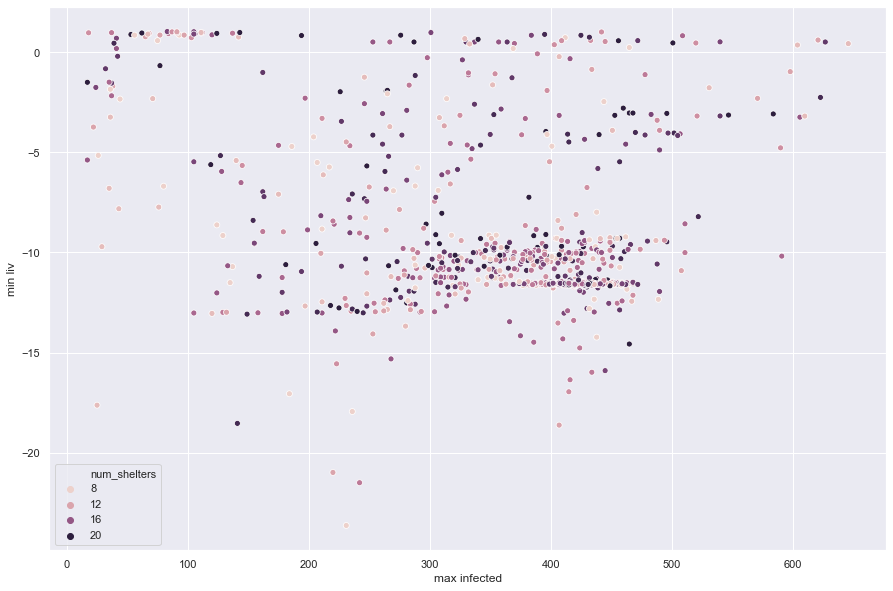

In [59]:
#What you see: max infected runs in relation to the size of the shelter in relation to the number of shelters

sns.scatterplot(data=z, x="max infected", y="min liv", hue ="num_shelters")
sns.set(rc={'figure.figsize':(15,10)})
plt.show()

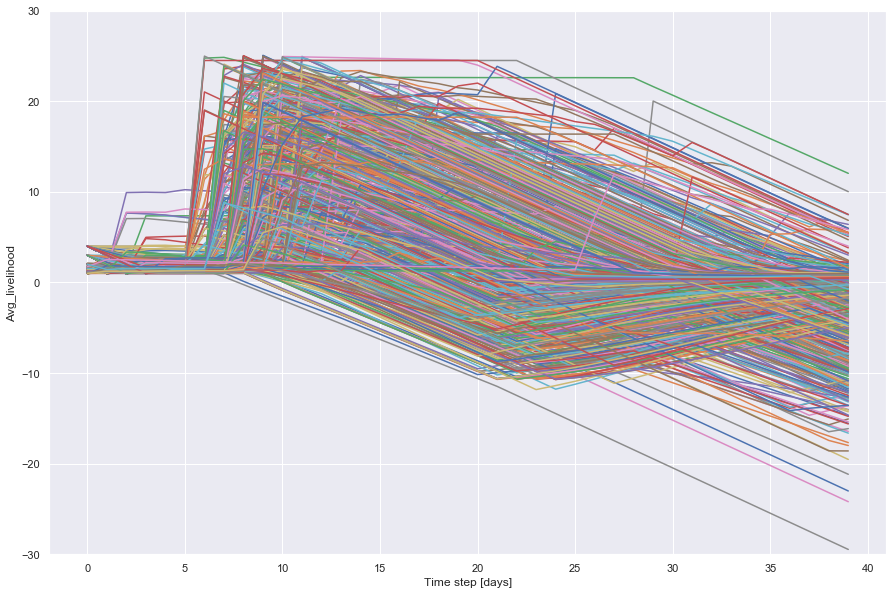

In [60]:
# plotting the adoption curves - here: for cash-transfer-only (p1)
from ema_workbench.analysis import plotting, plotting_util

for outcome in outcomes3c.keys():
    if outcome == 'Avg_livelihood':
        plotting.lines(experiments3c, outcomes3c, titles = None, outcomes_to_show=outcome)

plt.xlabel('Time step [days]')
plt.ylabel('Avg_livelihood')
plt.ylim(-30,30)
plt.show()

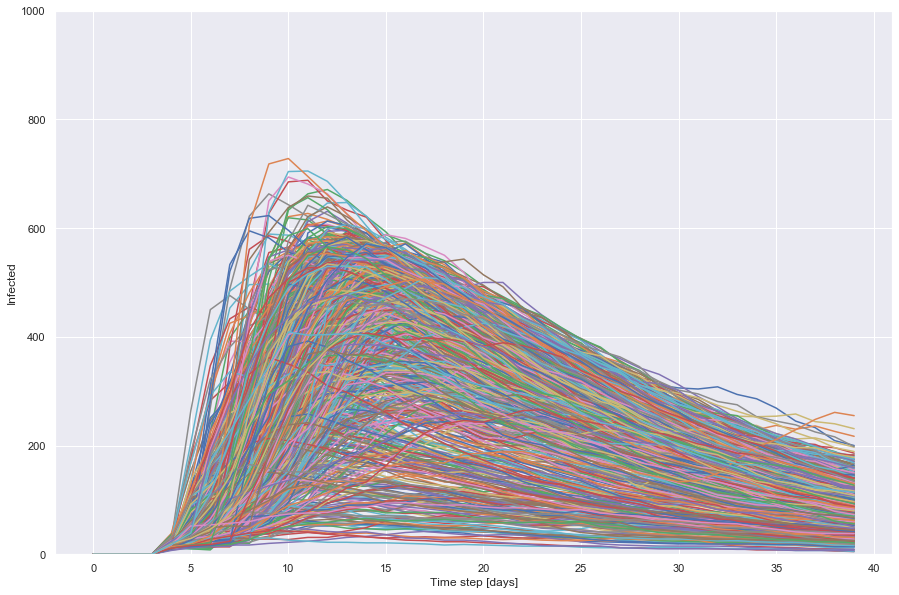

In [61]:
# plotting the adoption curves - here: for cash-transfer-only (p1)
from ema_workbench.analysis import plotting, plotting_util

for outcome in outcomes3c.keys():
    if outcome == 'Infected':
        plotting.lines(experiments3c, outcomes3c, titles = None, outcomes_to_show=outcome)

plt.xlabel('Time step [days]')
plt.ylabel('Infected')
plt.ylim(0, 1000)
plt.show()

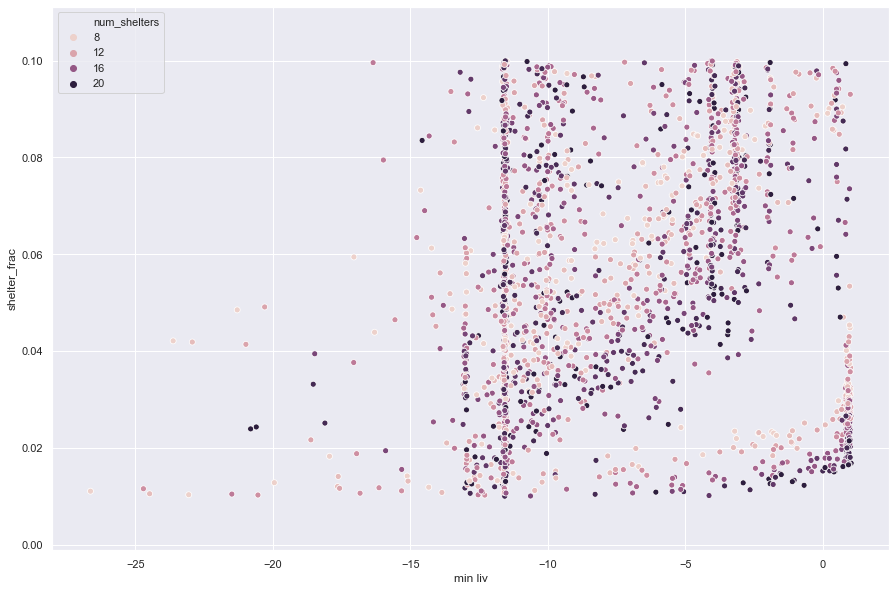

In [62]:
#see the number of shelters, minimum livelihood, shelter_frac
sns.scatterplot(data=zzz, x="min liv", y="shelter_frac", hue ="num_shelters")
sns.set(rc={'figure.figsize':(15,10)})
plt.show()

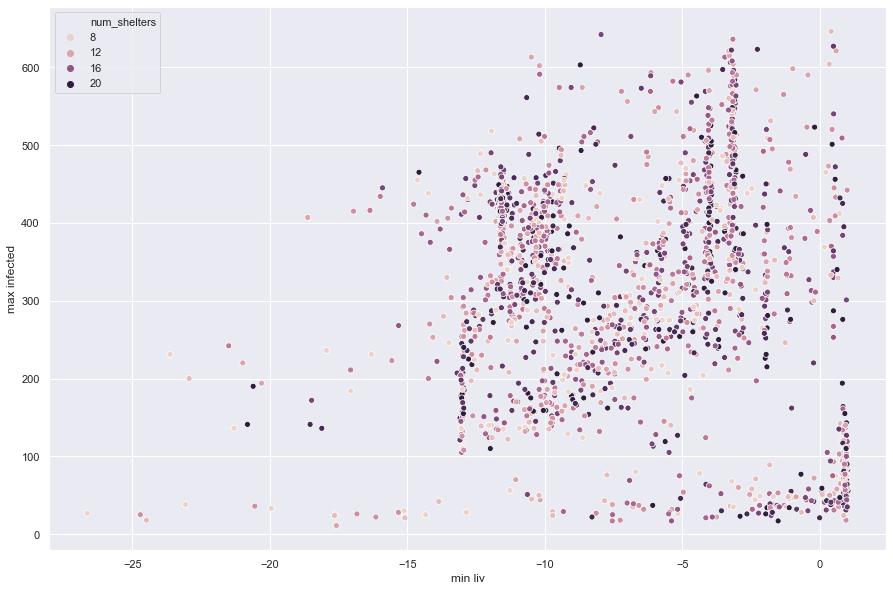

In [63]:
sns.scatterplot(data=zzz, x="min liv", y="max infected", hue ="num_shelters")
sns.set(rc={'figure.figsize':(15,10)})
plt.show()

In [64]:
zzz.head()

max infected  min liv  shelter_frac  num_shelters  total sick  \
0           370 -10.8405      0.090368          11.0        8458   
1           462 -11.5855      0.092420          15.0        9902   
2           421 -11.5860      0.043743          19.0        9362   
3           433   0.5800      0.094155          13.0        9742   
4           264  -1.9415      0.057300          20.0        6733   

   shelter_perc_meeting  Rv  
0              0.077724  <6  
1              0.074107  <6  
2              0.135236  <6  
3              0.064385  <6  
4              0.167173  <6

In [65]:
zzz.reset_index(drop=True, inplace=True)

In [66]:
zzz.num_shelters[2]

19.0

In [67]:
zzz['shelters'] = "A"
for i in range(len(zzz)):
    if zzz.num_shelters[i] > 9 and zzz.num_shelters[i] < 12:
        zzz.shelters[i] = "B"
    elif zzz.num_shelters[i] >11:
        zzz.shelters[i] = "C"
    else:
        pass

zzz.head()


C:\Users\fuukv\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\fuukv\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


max infected  min liv  shelter_frac  num_shelters  total sick  \
0           370 -10.8405      0.090368          11.0        8458   
1           462 -11.5855      0.092420          15.0        9902   
2           421 -11.5860      0.043743          19.0        9362   
3           433   0.5800      0.094155          13.0        9742   
4           264  -1.9415      0.057300          20.0        6733   

   shelter_perc_meeting  Rv shelters  
0              0.077724  <6        B  
1              0.074107  <6        C  
2              0.135236  <6        C  
3              0.064385  <6        C  
4              0.167173  <6        C

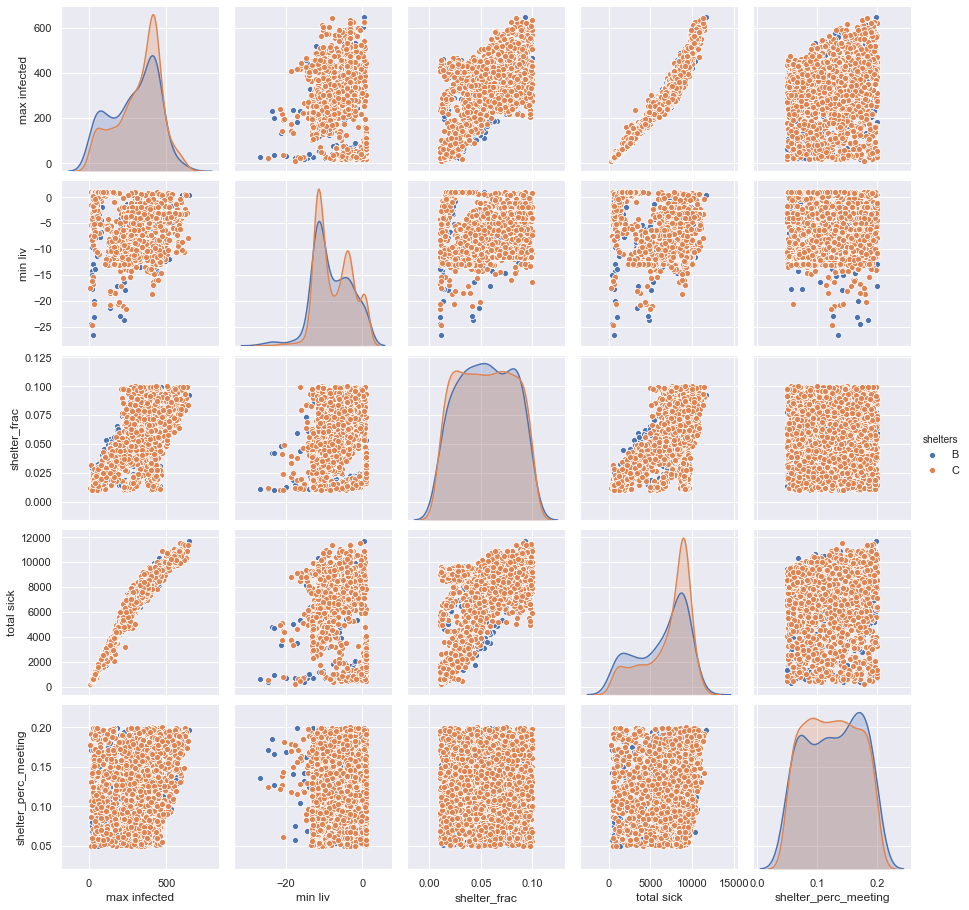

In [68]:
del zzz['num_shelters']
sns.pairplot(zzz, hue="shelters")



In [69]:
a = outcomes4a["Avg_livelihood"][np.arange(len(outcomes4a["Avg_livelihood"])), np.argmin(outcomes4a["Avg_livelihood"], axis=1)]
b = outcomes4b["Avg_livelihood"][np.arange(len(outcomes4b["Avg_livelihood"])), np.argmin(outcomes4b["Avg_livelihood"], axis=1)]
c = outcomes4c["Avg_livelihood"][np.arange(len(outcomes4c["Avg_livelihood"])), np.argmax(outcomes4c["Avg_livelihood"], axis=1)]
d = outcomes3c["Avg_livelihood"][np.arange(len(outcomes3c["Avg_livelihood"])), np.argmax(outcomes3c["Avg_livelihood"], axis=1)]

In [70]:
e = outcomes3c["Infected"][np.arange(len(outcomes3c["Infected"])), np.argmax(outcomes3c["Infected"], axis=1)]
e = pd.DataFrame(e)
e.columns = ["Peak infected"]
e["total sick days"] = pd.DataFrame(total_inf_3c)
e["sum neg liv"] = pd.DataFrame(nega_liv_3c)

In [71]:
a = pd.DataFrame(a)
b = pd.DataFrame(b)
c = pd.DataFrame(c)
d = pd.DataFrame(d)
a["Cash transfer"] = "low"
b["Cash transfer"] = "medium"
c["Cash transfer"] = "high"
a["Max_shelter_contacts"] = experiments4a['max_contacts_shelter']
b["Max_shelter_contacts"] = experiments4b['max_contacts_shelter']
c["Max_shelter_contacts"] = experiments4c['max_contacts_shelter']
d["Max_shelter_contacts"] = experiments3c['max_contacts_shelter']
a["Max_contacts"] = experiments4a['max_contacts']
b["Max_contacts"] = experiments4b['max_contacts']
c["Max_contacts"] = experiments4c['max_contacts']
d["Max_contacts"] = experiments3c['max_contacts']
a["init_liv"] = experiments4a['initial_live']
b["init_liv"] = experiments4b['initial_live']
c["init_liv"] = experiments4c['initial_live']
d["init_liv"] = experiments3c['initial_live']
d["cash transfer"] = experiments3c["height_cash"]

In [72]:
z = pd.concat([a,b,c])
z.columns = ["Min. avg livelihood","Cash transfer", 'Max_shelter_contacts', "max_contacts", 'initial_live']
d = pd.concat([d,e], axis = 1).reindex(d.index)

In [73]:
e.head()

Peak infected  total sick days  sum neg liv
0            498             9813      -68.762
1            453             9339        0.000
2            520             9786        0.000
3            425             9039        0.000
4            455             9025        0.000

In [74]:

d.columns = ["Min. avg livelihood", 'Max_shelter_contacts', "max_contacts", 'initial_live', "cash", "peak inf", "total sick days", "sum neg liv"]

d.head()

Min. avg livelihood  Max_shelter_contacts  max_contacts  initial_live  \
0               7.8880                   5.0           9.0           1.0   
1              13.6440                   6.0           6.0           3.0   
2              21.1245                  14.0           7.0           5.0   
3              23.9480                  18.0           5.0           5.0   
4              22.6830                  22.0           8.0           1.0   

   cash  peak inf  total sick days  sum neg liv  
0   8.0       498             9813      -68.762  
1  14.0       453             9339        0.000  
2  22.0       520             9786        0.000  
3  24.0       425             9039        0.000  
4  25.0       455             9025        0.000

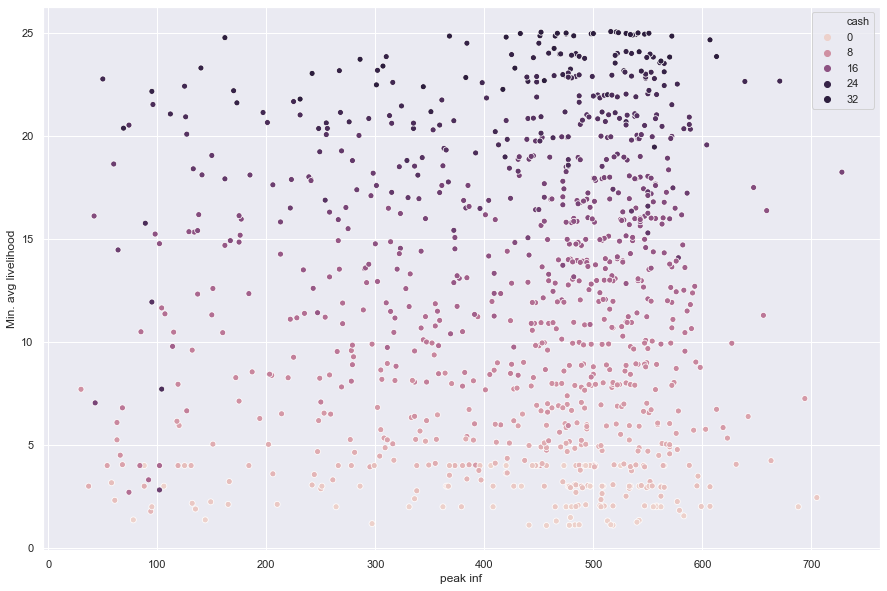

In [75]:
sns.scatterplot(data=d, x="peak inf", y="Min. avg livelihood", hue ="cash")

In [76]:
aa = a #min livelihood
bb = nega_liv_4c #total neg livelihood
aa = pd.DataFrame(aa)
aa["total neg liv"] = pd.DataFrame(bb)
aa["init_liv"] = experiments4c['initial_live']
aa.columns = ["minimum liv", "total neg liv", "init liv"]

ValueError: Length mismatch: Expected axis has 6 elements, new values have 3 elements

In [77]:
aa.head()

0 Cash transfer  Max_shelter_contacts  Max_contacts  init_liv  \
0  0.9205           low                  15.0           3.0       2.0   
1 -7.3430           low                  16.0           3.0       2.0   
2  0.7175           low                  13.0           5.0       5.0   
3  0.6820           low                  11.0           5.0       2.0   
4  0.9375           low                  13.0           3.0       5.0   

   total neg liv  
0          0.000  
1          0.000  
2          0.000  
3        -43.733  
4          0.000

In [78]:
sns.scatterplot(data=aa, x="minimum liv", y="total neg liv", hue ="init liv")
sns.set(rc={'figure.figsize':(15,10)})
plt.show()

ValueError: Could not interpret input 'minimum liv'

KeyError: 'init liv'

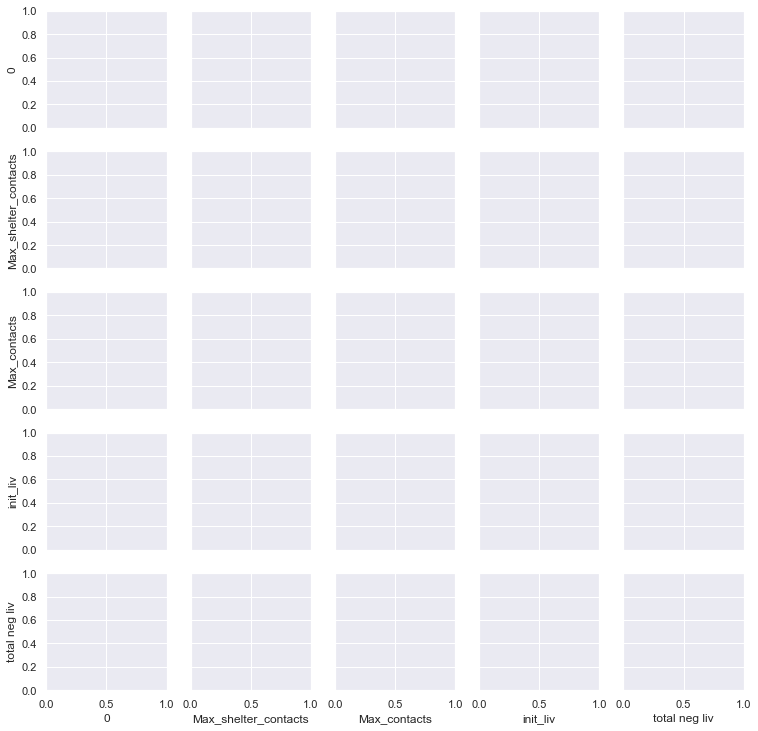

In [79]:
sns.pairplot(aa, hue="init liv")

In [ ]:
# # Load an example dataset with long-form data
# fmri = sns.load_dataset("fmri")

# # Plot the responses for different events and regions
# sns.lineplot(x="timepoint", y="signal",
#              hue="region", style="event",
#              data=fmri)

In [ ]:
df.head()

In [ ]:
#outcomes0["Avg_livelihood"][np.arange(len(outcomes0["Avg_livelihood"])), np.argmin(outcomes0["Avg_livelihood"], axis=1)]

In [ ]:
list_neg_liv0 = []

for i in range(len(outcomes0["Avg_livelihood"])):
    neg_liv = 0
    for j in range(40):
        if outcomes0["Avg_livelihood"][i][j] <= 0:
            neg_liv += outcomes0["Avg_livelihood"][i][j]
    list_neg_liv0.append(neg_liv)


In [80]:
list_neg_liv1a = []
for i in range(len(outcomes1a["Avg_livelihood"])):
    neg_liv = 0
    for j in range(40):
        if outcomes1a["Avg_livelihood"][i][j] <= 0:
            neg_liv += outcomes1a["Avg_livelihood"][i][j]
    list_neg_liv1a.append(neg_liv)

In [81]:
list_neg_liv1b = []
for i in range(len(outcomes1b["Avg_livelihood"])):
    neg_liv = 0
    for j in range(40):
        if outcomes1b["Avg_livelihood"][i][j] <= 0:
            neg_liv += outcomes1b["Avg_livelihood"][i][j]
    list_neg_liv1b.append(neg_liv)

In [82]:
list_neg_liv2a = []
for i in range(len(outcomes2a["Avg_livelihood"])):
    neg_liv = 0
    for j in range(40):
        if outcomes2a["Avg_livelihood"][i][j] <= 0:
            neg_liv += outcomes2a["Avg_livelihood"][i][j]
    list_neg_liv2a.append(neg_liv)

In [83]:
list_neg_liv2b = []
for i in range(len(outcomes2b["Avg_livelihood"])):
    neg_liv = 0
    for j in range(40):
        if outcomes2b["Avg_livelihood"][i][j] <= 0:
            neg_liv += outcomes2b["Avg_livelihood"][i][j]
    list_neg_liv2b.append(neg_liv)

In [84]:
list_neg_liv3a = []
for i in range(len(outcomes3a["Avg_livelihood"])):
    neg_liv = 0
    for j in range(40):
        if outcomes3a["Avg_livelihood"][i][j] <= 0:
            neg_liv += outcomes3a["Avg_livelihood"][i][j]
    list_neg_liv3a.append(neg_liv)

In [85]:
list_neg_liv3b = []
for i in range(len(outcomes3b["Avg_livelihood"])):
    neg_liv = 0
    for j in range(40):
        if outcomes3b["Avg_livelihood"][i][j] <= 0:
            neg_liv += outcomes3b["Avg_livelihood"][i][j]
    list_neg_liv3b.append(neg_liv)

In [86]:
list_neg_liv4a = []
for i in range(len(outcomes4a["Avg_livelihood"])):
    neg_liv = 0
    for j in range(40):
        if outcomes4a["Avg_livelihood"][i][j] <= 0:
            neg_liv += outcomes4a["Avg_livelihood"][i][j]
    list_neg_liv4a.append(neg_liv)

In [87]:
list_neg_liv4b = []
for i in range(len(outcomes4b["Avg_livelihood"])):
    neg_liv = 0
    for j in range(40):
        if outcomes4b["Avg_livelihood"][i][j] <= 0:
            neg_liv += outcomes4b["Avg_livelihood"][i][j]
    list_neg_liv4b.append(neg_liv)

In [88]:
list_neg_liv4c = []
for i in range(len(outcomes4c["Avg_livelihood"])):
    neg_liv = 0
    for j in range(40):
        if outcomes4c["Avg_livelihood"][i][j] <= 0:
            neg_liv += outcomes4c["Avg_livelihood"][i][j]
    list_neg_liv4c.append(neg_liv)

NameError: name 'list_neg_liv' is not defined

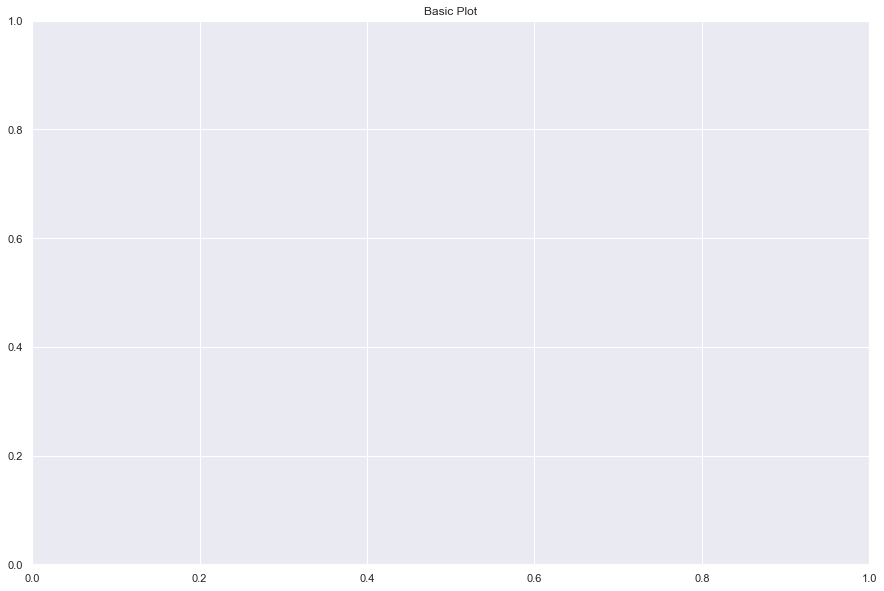

In [89]:
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(list_neg_liv)
plt.show()

In [90]:
# creating boxplots to compare interventions based on the KPIs
sns.boxplot(x = ['BM', 'p1a', 'p1b', 'p2a', 'p2b', 'p3a', 'p3b', 'p4a', 'p4b','p4c'], 
            y=[ list_neg_liv0,
                list_neg_liv1a,  
              list_neg_liv1b,
             list_neg_liv2a, list_neg_liv2b, 
               list_neg_liv3a, list_neg_liv3b, list_neg_liv4a, list_neg_liv4b, 
                list_neg_liv4c] , 
            palette = 'Blues')
sns.set(rc={'figure.figsize':(15,10)})
plt.ylabel('Livelihood')
plt.xlabel('Policies')
plt.title('Negative livelihood per policy')
plt.show()

NameError: name 'list_neg_liv0' is not defined

KeyError: 'species'

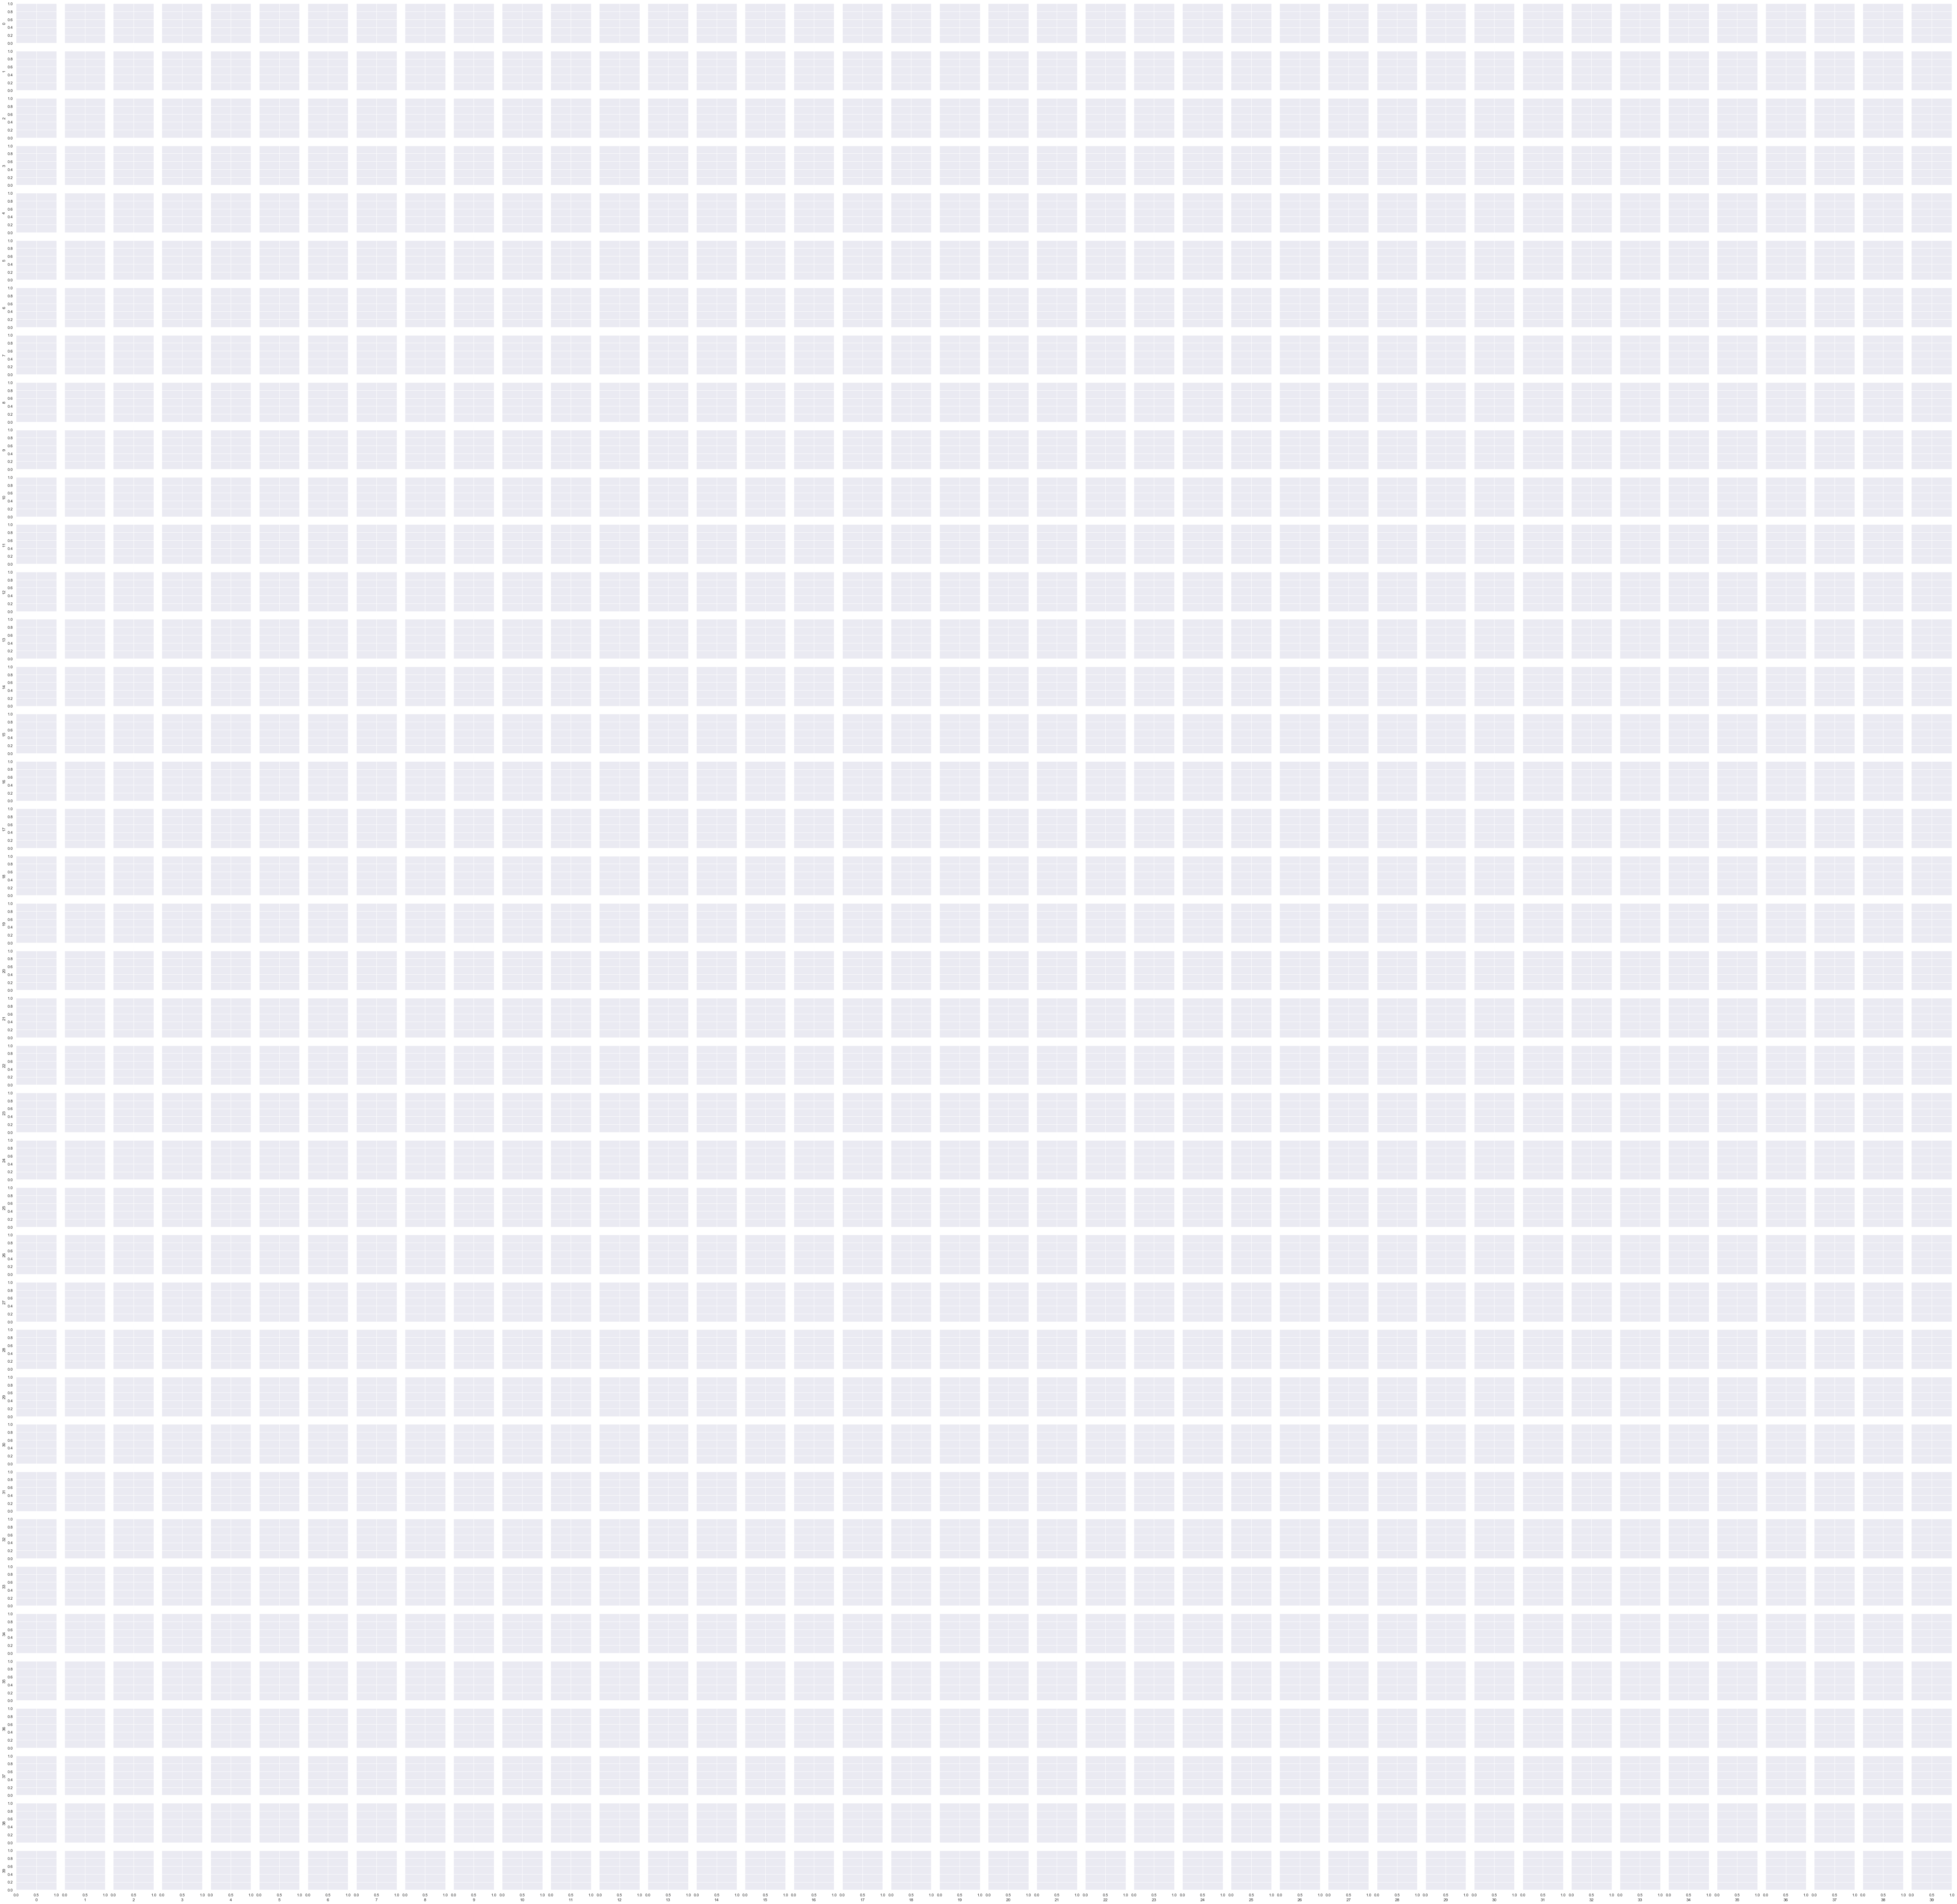

In [91]:

sns.pairplot(df, hue="species")

In [ ]:
#PRIMPRIMPRIMROSEEVERDEEN

In [92]:
del outcomes0["shelter_pop"]

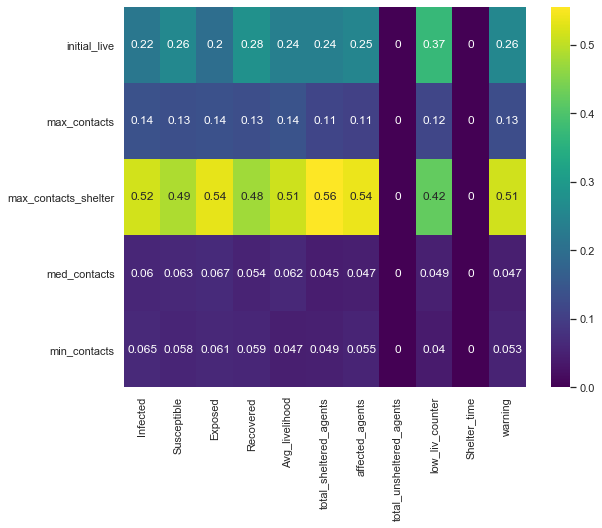

In [93]:
fig, ax = plt.subplots(figsize=(9,7))  
scores = feature_scoring.get_feature_scores_all(experiments0, outcomes0)
sns.heatmap(scores, cmap='viridis', annot=True, ax=ax)
plt.show()

In [31]:
# del outcomes0['shelter_pop']
# del outcomes1a['shelter_pop']
#del outcomes1b['shelter_pop']
#del outcomes2a['shelter_pop']
#del outcomes2b['shelter_pop']
del outcomes3a['shelter_pop']
del outcomes3b['shelter_pop']
del outcomes4a['shelter_pop']
del outcomes4b['shelter_pop']
del outcomes4c['shelter_pop']


In [34]:
# del outcomes0['total_unsheltered_agents']
# del outcomes1a['total_unsheltered_agents']
#del outcomes1b['total_unsheltered_agents']
#del outcomes2a['total_unsheltered_agents']
#del outcomes2b['total_unsheltered_agents']
del outcomes3a['total_unsheltered_agents']
del outcomes3b['total_unsheltered_agents']
del outcomes4a['total_unsheltered_agents']
del outcomes4b['total_unsheltered_agents']
del outcomes4c['total_unsheltered_agents']

In [38]:
del outcomes0['Shelter_time']
del outcomes3a['Shelter_time']
del outcomes3b['Shelter_time']
del outcomes4a['Shelter_time']
del outcomes4b['Shelter_time']
del outcomes4c['Shelter_time']

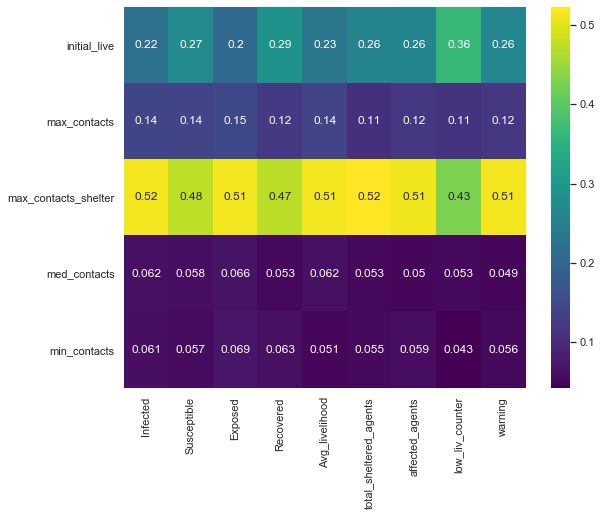

In [39]:
fig, ax = plt.subplots(figsize=(9,7))  
scores = feature_scoring.get_feature_scores_all(experiments0, outcomes0)
sns.heatmap(scores, cmap='viridis', annot=True, ax=ax)
plt.show()

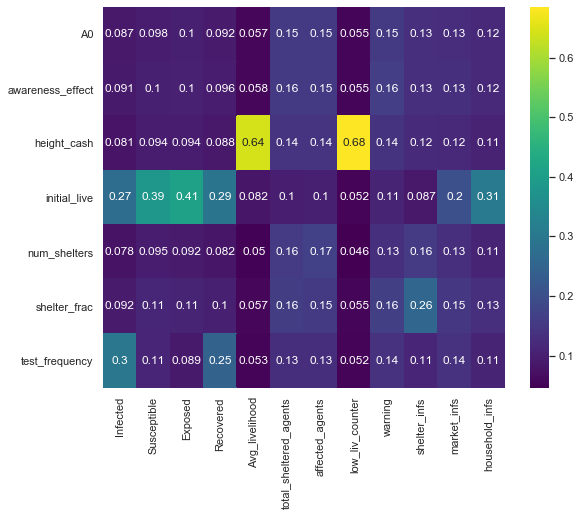

In [40]:
fig, ax = plt.subplots(figsize=(9,7))  
scores = feature_scoring.get_feature_scores_all(experiments1a, outcomes1a)
sns.heatmap(scores, cmap='viridis', annot=True, ax=ax)
plt.show()

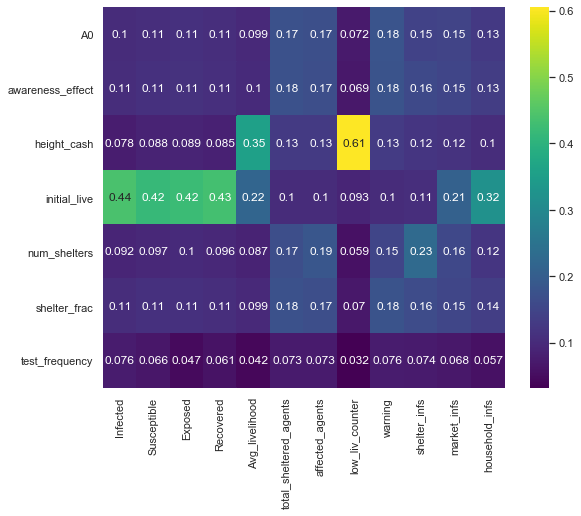

In [41]:
fig, ax = plt.subplots(figsize=(9,7))  
scores = feature_scoring.get_feature_scores_all(experiments1b, outcomes1b)
sns.heatmap(scores, cmap='viridis', annot=True, ax=ax)
plt.show()

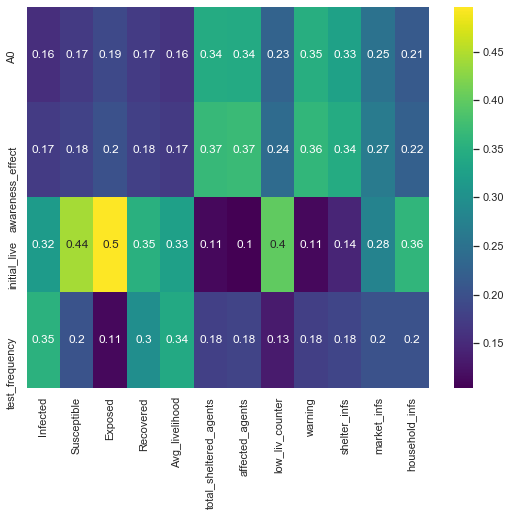

In [42]:
fig, ax = plt.subplots(figsize=(9,7))  
scores = feature_scoring.get_feature_scores_all(experiments2a, outcomes2a)
sns.heatmap(scores, cmap='viridis', annot=True, ax=ax)
plt.show()

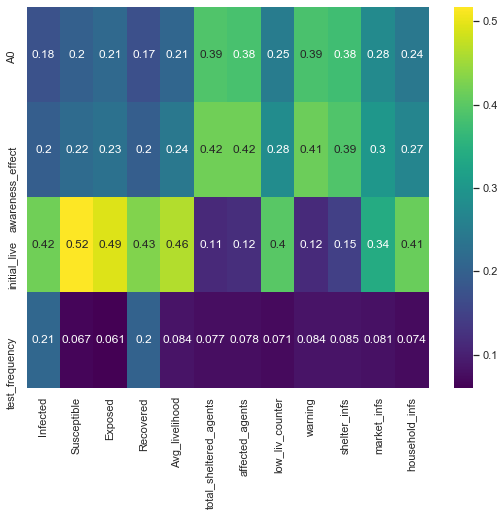

In [43]:
fig, ax = plt.subplots(figsize=(9,7))  
scores = feature_scoring.get_feature_scores_all(experiments2b, outcomes2b)
sns.heatmap(scores, cmap='viridis', annot=True, ax=ax)
plt.show()

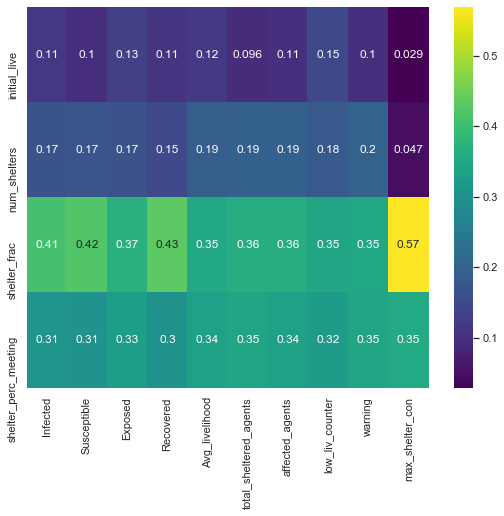

In [44]:
fig, ax = plt.subplots(figsize=(9,7))  
scores = feature_scoring.get_feature_scores_all(experiments3a, outcomes3a)
sns.heatmap(scores, cmap='viridis', annot=True, ax=ax)
plt.show()

In [45]:
del outcomes3b["Shelter_time"]

KeyError: 'Shelter_time'

In [ ]:
del experiments3b["initial_live"]

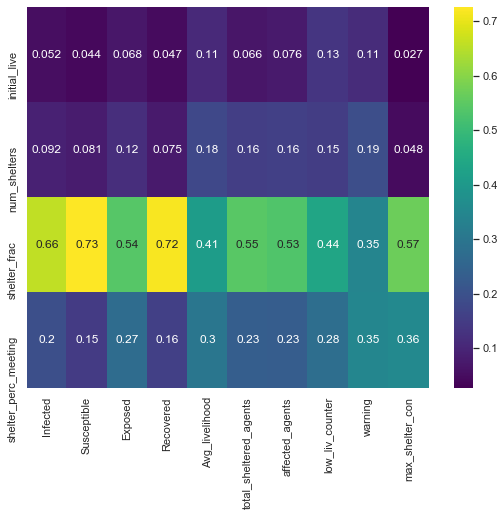

In [46]:
fig, ax = plt.subplots(figsize=(9,7))  
scores = feature_scoring.get_feature_scores_all(experiments3b, outcomes3b)
sns.heatmap(scores, cmap='viridis', annot=True, ax=ax)
plt.show()

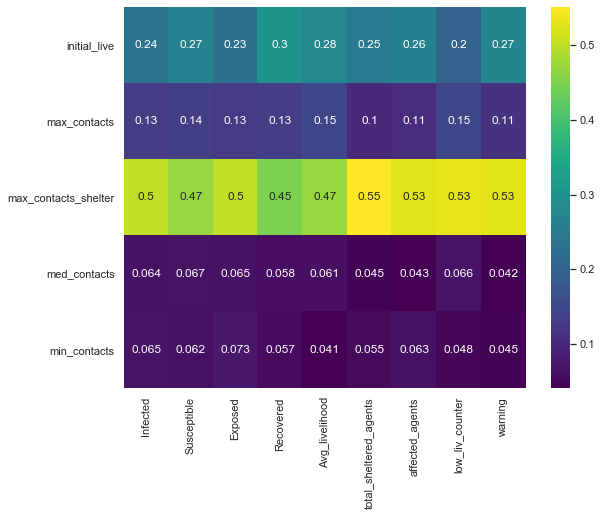

In [47]:
fig, ax = plt.subplots(figsize=(9,7))  
scores = feature_scoring.get_feature_scores_all(experiments4a, outcomes4a)
sns.heatmap(scores, cmap='viridis', annot=True, ax=ax)
plt.show()

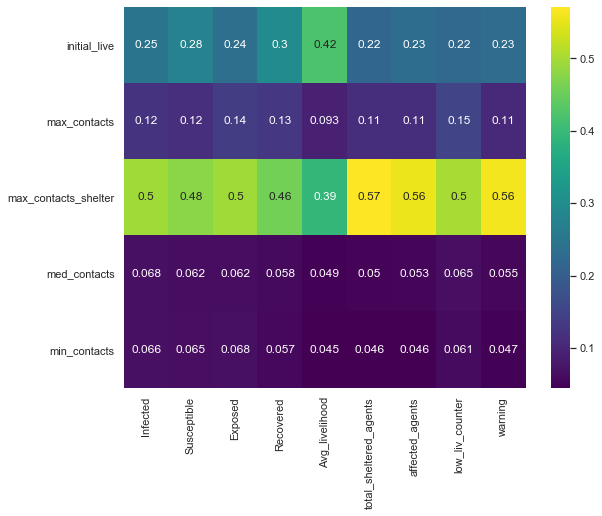

In [48]:
fig, ax = plt.subplots(figsize=(9,7))  
scores = feature_scoring.get_feature_scores_all(experiments4b, outcomes4b)
sns.heatmap(scores, cmap='viridis', annot=True, ax=ax)
plt.show()

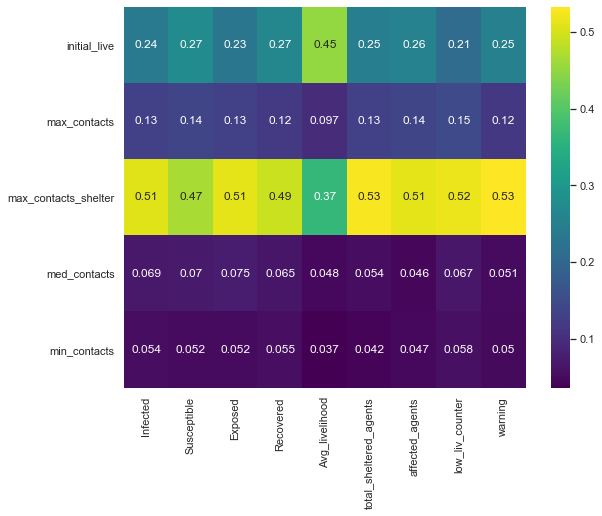

In [49]:
fig, ax = plt.subplots(figsize=(9,7))  
scores = feature_scoring.get_feature_scores_all(experiments4c, outcomes4c)
sns.heatmap(scores, cmap='viridis', annot=True, ax=ax)
plt.show()

In [ ]:
#PRIMMERTJE FOR LIVELIHOOD

In [ ]:
# plotting the adoption curves - here: for cash-transfer-only (p1)
from ema_workbench.analysis import plotting, plotting_util

for outcome in outcomes0.keys():
    if outcome == 'Avg_livelihood':
        plotting.lines(experiments0, outcomes0, titles = None, outcomes_to_show=outcome)

plt.xlabel('Time step [days]')
plt.ylabel('Avg_livelihood')
plt.ylim(-20, 10)
plt.show()

In [ ]:
# define outcomes of interest
# PRIM for p4 with shocks
liv = outcomes0['Avg_livelihood']
#select indices where livelihood were min
min_livelihood = liv[np.arange(len(liv)), np.argmin(liv, axis=1)]
y = min_livelihood < np.percentile(min_livelihood, 25) #25 is TRUE

# apply PRIM algorithm to map outcomes of interest to sub-spaces in uncertainty space (scenarios)
prim_alg = prim.Prim(experiments0, y, threshold=0.55, peel_alpha = 0.01)
box1 = prim_alg.find_box()

In [ ]:
# plotting the parameter ranges found by PRIM
box1.inspect(style='graph')
plt.show()

In [ ]:
box1.show_tradeoff()
plt.show()

In [ ]:
####PRIMMERTJE VOOR INFECTIONS

In [ ]:
inf = outcomes0['Infected']
max_infected_per_run = inf[np.arange(len(inf)), np.argmax(inf, axis=1)]
y = max_infected_per_run < np.percentile(max_infected_per_run, 80)

# apply PRIM algorithm to map outcomes of interest to sub-spaces in uncertainty space (scenarios)
prim_alg = prim.Prim(experiments0, y, threshold=0.9, peel_alpha = 0.1)
box1 = prim_alg.find_box()

In [ ]:
# plotting the parameter ranges found by PRIM
box1.inspect(style='graph')
plt.show()

In [ ]:
box1.show_tradeoff()
plt.show()

In [ ]:
#subconclusion: setting the shelter contacts to max 12 would be good for having less infections 
#(20% highest cases had between 12 and 18 contacts while staying in the shelter.)


# thoughts: what are nice kpis to consider? Currently, the prim algorithm is not finding any particular uncertainty to tweek with policy interventions
# but that is probably because the KPIs are not saying that much

## Try later

In [ ]:
sns.pairplot(pd.DataFrame.from_dict(outcomes))
plt.show()

In [ ]:
# plotting the adoption curves - here: for cash-transfer-only (p1)
from ema_workbench.analysis import plotting, plotting_util

for outcome in outcomes0.keys():
    if outcome == 'Infected':
        plotting.lines(experiments0, outcomes0, titles = None, outcomes_to_show=outcome)

plt.xlabel('Time step [days]')
plt.ylabel('Avg_livelihood')
plt.ylim(0, 1000)
plt.show()

In [ ]:
#delve into policy 3 and 4

In [ ]:
# plotting the adoption curves - here: for cash-transfer-only (p1)
from ema_workbench.analysis import plotting, plotting_util

for outcome in outcomes3a.keys():
    if outcome == 'Infected':
        plotting.lines(experiments3a, outcomes3a, titles = None, outcomes_to_show=outcome)

plt.xlabel('Time step [days]')
plt.ylabel('Avg_livelihood')
plt.ylim(0, 1000)
plt.show()

In [ ]:
# plotting the adoption curves - here: for cash-transfer-only (p1)
from ema_workbench.analysis import plotting, plotting_util

for outcome in outcomes3b.keys():
    if outcome == 'Infected':
        plotting.lines(experiments3b, outcomes3b, titles = None, outcomes_to_show=outcome)

plt.xlabel('Time step [days]')
plt.ylabel('Avg_livelihood')
plt.ylim(0, 1000)
plt.show()

In [ ]:
# define outcomes of interest - here: success above 75th percentile, or failure below 25th percentile
# PRIM for p4 with shocks
inf =  outcomes3a['Infected']
max_infected_per_run = inf[np.arange(len(inf)), np.argmax(inf, axis=1)]
y = max_infected_per_run < np.percentile(max_infected_per_run, 25)

# apply PRIM algorithm to map outcomes of interest to sub-spaces in uncertainty space (scenarios)
prim_alg = prim.Prim(experiments3a, y, threshold=0.71, peel_alpha = 0.1)
box1 = prim_alg.find_box()

In [ ]:
#max_infected_per_run


In [ ]:
# plotting the parameter ranges found by PRIM
box1.inspect(style='graph')
plt.show()

In [ ]:
box1.show_tradeoff()
plt.show()

In [ ]:
# define outcomes of interest - here: success above 75th percentile, or failure below 25th percentile
# PRIM for p4 with shocks
inf =  outcomes3a['Infected']
max_infected_per_run = inf[np.arange(len(inf)), np.argmax(inf, axis=1)]
y = max_infected_per_run > np.percentile(max_infected_per_run, 75)

# apply PRIM algorithm to map outcomes of interest to sub-spaces in uncertainty space (scenarios)
prim_alg = prim.Prim(experiments3a, y, threshold=0.78, peel_alpha = 0.1)
box1 = prim_alg.find_box()
# plotting the parameter ranges found by PRIM
box1.inspect(style='graph')
plt.show()
box1.show_tradeoff()
plt.show()


In [ ]:
##SENSITIVITY ANALYSIS

In [ ]:
plt.plot(outcomes0["Infected"][0], label = "inf")
plt.plot(outcomes0["Exposed"][0], label = 'exp')
plt.plot(outcomes0["Susceptible"][0], label = 'sus')
plt.plot(outcomes0["Recovered"][0], label = 'rec')
plt.title("SEIR curve of base model")
plt.xlabel("number of days")
plt.ylabel("number of agents")
plt.legend()
plt.show()

In [ ]:
inf = pd.DataFrame(outcomes0["Infected"])
sus = pd.DataFrame(outcomes0["Susceptible"] )
rec = pd.DataFrame(outcomes0["Recovered"] )
exp = pd.DataFrame(outcomes0["Exposed"] )

inf.mean().plot(label = 'inf')
sus.mean().plot(label = "sus")
rec.mean().plot(label = "rec")
exp.mean().plot(label = "exp")

plt.title("SEIR curve of base model")
plt.xlabel("number of days")
plt.ylabel("number of agents")
plt.legend()
plt.show()

In [ ]:
df = pd.DataFrame({'Country': ['UK', 'US'],
                   '2006': [1, 2],
                   '2007': [3, 4],
                   '2008': [5, 6]})

In [ ]:
df